# **Neural Network**

In [1]:
# Set the condition

subject_pool = [1, 2, 3, 4, 5, 6, 7, 12, 13]

subject_test_list = [12, 13]

# subject_validation = 2

subject_list = [subject for subject in subject_pool if subject not in subject_test_list]

############################

EEG_channel_list = [3] # channel 3 (Fp1) is the best rn

data_scaling = int(3) # scaling 3 (normal scale) is the best rn

excluded_columns = ['Initial_KSS', 'VLF', 'LF', 'HF', 'ORD class', 'class name', 'subject']
columns_not_to_scale = ['Epoch_minute']

numClasses = 3 # 2:binary, 3:3classes

smote = 0 # 0:No (use class_weight instead), 1:Yes # 0 is better

seed = 42

initial_kss = [7, 6, 5, 5, 5, 5, 5, 7, 6, 4, 5, 6, 7, 6, 5]

In [2]:
subject_list

[1, 2, 3, 4, 5, 6, 7]

In [3]:
if data_scaling == 1:
    print('True')

In [4]:
import numpy as np
import tensorflow as tf
import random as python_random

np.random.seed(seed)
python_random.seed(seed)
tf.random.set_seed(seed)

## **1. Import Libraries**

In [5]:
import pandas as pd # pandas is ised to load and manipulate data and for One-Hot Encoding
import numpy as np # data manipulation
import matplotlib.pyplot as plt # matplotlib is for drawing graph
import matplotlib.colors as colors # 
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold # split data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.svm import SVC # support vector machine classification
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # cross validation

from sklearn.metrics import confusion_matrix # create confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # draw confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report
from sklearn.decomposition import PCA # perform PCA to plot the data
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE


from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

import pickle  
import joblib 


# import matlab data
from scipy.io import loadmat

import seaborn as sns

## **2. Function**

In [6]:
def load_subject_data(subject_number):
    # [INPUT: EEG & ECG data] load the .mat file
    data_path = f'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/EEG_ECG_Features/EEG_ECG_Features_subject{subject_number}.mat'
    data = loadmat(data_path)
    ECG_features = data['ECG_features']
    EEG_features = data['EEG_features']
    channelList_pre = data['channelList'][0]
    channelList = []
    for i in range(len(channelList_pre)):
        channelList.append(channelList_pre[i][0])
    
    # [OUTPUT: ORD] load the .xlsx file
    ord_filepath = 'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/ORD_labels.xlsx'
    xl = pd.ExcelFile(ord_filepath)
    sheet_name = xl.sheet_names[subject_number-1] # access the subject's sheet by index
    ord_60min = pd.read_excel(ord_filepath, sheet_name=sheet_name)
    
    return ECG_features, EEG_features, ord_60min, channelList

In [7]:
def ECG_dataframe(subject, ECG_features_allcases):
    ECG_features_py = []
    
    # Loop through each struct in the struct array
    for i in range(ECG_features_allcases[subject].shape[0]):  # Adjusted loop for Nx1 struct array
        struct = ECG_features_allcases[subject][i, 0]
        scalar_dict = {
            'Index': struct['Index'][0, 0],
            'VLF': struct['VLF'][0, 0],
            'LF': struct['LF'][0, 0],
            'HF': struct['HF'][0, 0],
            'LFHF': struct['LFHF'][0, 0],
            'pLF': struct['pLF'][0, 0],
            'pHF': struct['pHF'][0, 0]
        }
        ECG_features_py.append(scalar_dict)

    # Convert scalar values to DataFrame
    ECG_features_df = pd.DataFrame(ECG_features_py)
    
    return ECG_features_df

In [8]:
def EEG_dataframe_list(subject, EEG_features_allcases, channelList_allcases):
    
    EEG_features_df_list = []

    numEEGchannels = EEG_features_allcases[subject].shape[1]
    numEEGepochs = EEG_features_allcases[subject].shape[0]
    EEG_featurelist = ['Epoch', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative', 'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio']

    # Assuming struct_array is of shape (139, 12), iterate through each struct
    for channel in range(numEEGchannels):  # for j in range(12)
        channelfeatures = []
        for epoch in range(numEEGepochs):  # for i in range(139)
            epochfeatures = {field: EEG_features_allcases[subject][epoch, channel][field][0,0] for field in EEG_featurelist}
            channelfeatures.append(epochfeatures)
        
        channelfeatures_df = pd.DataFrame(channelfeatures)
        EEG_features_df_list.append(channelfeatures_df)

    # if numEEGchannels != 12:
    #     channelSubject = channelList_allcases[subject]
    #     channelAll = ['o1', 'o2', 'fp1', 'fp2', 'p7', 'p8', 'p3', 'p4', 'f3', 'f4', 't7', 't8']
    #     # for i in range(len(channelAll)):
    #     #     if channelSubject[i] != channelAll[i]:
    #     #         EEG_features_df_list.insert(i, [])
    #     n = 0
    #     for i in range(len(channelAll)):
    #         if channelSubject[i-n] != channelAll[i]:
    #             EEG_features_df_list.insert(i, [])
    #             n += 1
    # Initialize a temporary list to store the new structure
    
    channelSubject = channelList_allcases[subject]
    channelAll = ['o1', 'o2', 'fp1', 'fp2', 'p7', 'p8', 'p3', 'p4', 'f3', 'f4', 't7', 't8']

    temp_EEG_features_list = []
    subject_index = 0

    # Iterate over all possible channels in the complete list
    for channel in channelAll:
        if subject_index < len(channelSubject) and channel == channelSubject[subject_index]:
            # If the channel matches the subject's channel, add the corresponding DataFrame
            temp_EEG_features_list.append(EEG_features_df_list[subject_index])
            subject_index += 1  # Move to the next index in the subject's channel list
        else:
            # If there is no match, add an empty list
            temp_EEG_features_list.append([])

    # Update the original EEG_features_df_list to reflect the new structure
    EEG_features_df_list = temp_EEG_features_list
        
    return EEG_features_df_list

In [9]:
def ord_dataframe(subject, ord_60min_allcases, numClasses):
    
    # 1) ord_60min -> ord_epoch
    ord_epoch = []
    rater = 3

    for i in range(len(ord_60min_allcases[subject]) - 1):
        # Append the current ORD value
        ord_epoch.append(ord_60min_allcases[subject].iloc[i, rater])
        
        # Calculate and append the mean of the current and next ORD values
        mean_ord = np.mean([ord_60min_allcases[subject].iloc[i, rater], ord_60min_allcases[subject].iloc[i + 1, rater]])
        ord_epoch.append(mean_ord)

    # Append the last ORD value since it won't have a subsequent value to average with
    ord_epoch.append(ord_60min_allcases[subject].iloc[-1, rater])

    # Convert the list to a DataFrame and set the column title as 'ord score'
    ord_epoch = pd.DataFrame(ord_epoch, columns=['ORD score'])

    #######################################

    # 2) Simplify to 3 classes
    # ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (0 if x <= 2 else (1 if x <= 3 else 2)))
    if numClasses == 3:
        ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (int(1) if x <= 2 else (int(2) if x <= 3 else int(3)))) # 3-class
    # ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (1 if x <= 2 else (2 if x <= 3 else 3)))
    elif numClasses == 2:
        ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (1 if x <= 2 else (2))) # binary


    # Mapping from 'ORD class' to 'class name'
    class_name_mapping = {
        1: 'Alert',
        2: 'Moderately Drowsy',
        3: 'Extremely Drowsy'
    }

    # Add 'class name' column by mapping 'ORD class' to names
    ord_epoch['class name'] = ord_epoch['ORD class'].map(class_name_mapping)

    return ord_epoch
    

In [10]:
def combined_dataframe(EEG_features_df, ECG_features_df, ord_epoch):
    # EEG_features_df (df 139x7): row 10-128, column 1-6
    # ECG_features_df (df 139x7): row 10-128, column 1-6
    # ord_epoch (df 119x3): all row, column 1-2

    # 1) Select the specified rows and columns from each DataFrame
    # EEG_features_selected = EEG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
    # EEG_features_selected = EEG_features_df.loc[10:129, EEG_features_df.columns != 'Epoch']
    ECG_features_selected = ECG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
    Epoch_minute = pd.DataFrame({'Epoch_minute': np.linspace(1, 1 + 0.5 * (119 - 1), 119)})
    ord_epoch_selected = ord_epoch.iloc[:, 1:3]  # Columns 1-2

    if not EEG_features_df.empty:
        EEG_features_selected = EEG_features_df.loc[10:129, ~EEG_features_df.columns.str.startswith('Epoch')]



    # 2) Combine these features into a new DataFrame
    # Concatenate EEG and ECG features along the columns
        combined_data = pd.concat([
                                    Epoch_minute.reset_index(drop=True),
                                    EEG_features_selected.reset_index(drop=True), 
                                    ECG_features_selected.reset_index(drop=True),
                                    ord_epoch_selected.reset_index(drop=True)], axis=1)
    else:
        combined_data = pd.concat([
                                    Epoch_minute.reset_index(drop=True),
                                    ECG_features_selected.reset_index(drop=True),
                                    ord_epoch_selected.reset_index(drop=True)], axis=1)        
    # combined_data = combined_data.dropna()

    # Now combined_data contains your inputs (EEG and ECG features) and outputs (ORD class and class name)
    return combined_data

In [11]:
def classwise_accuracy(model, X_test_scaled, y_test):
    # Predict the labels for the test set
    y_pred = model.predict(X_test_scaled)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate accuracy for each class
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    # Define class names mapping
    class_names = {
        1: 'Alert',
        2: 'Moderately Drowsy',
        3: 'Extremely Drowsy'
    }
    
    # Print accuracy for each class
    for i, accuracy in enumerate(class_accuracies, start=1):
        class_name = class_names.get(i, f"Class {i}")
        print(f"Accuracy of {class_name}: {accuracy * 100:.4f}%")

    # Separator
    print("-" * 40)
    
    # Calculate and print F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro') # Aggregates the contributions of all classes to compute the average F1 score. Focuses on overall performance.
    weighted_f1 = f1_score(y_test, y_pred, average='weighted') # Computes the F1 score for each class, but uses the number of true instances for each class as weight.
    macro_f1 = f1_score(y_test, y_pred, average='macro') # Computes the F1 score separately for each class and then takes the average. Treats all classes equally.
    
    print(f"Micro-average F1: {micro_f1 * 100:.4f}%") 
    print(f"Weighted-average F1: {weighted_f1 * 100:.4f}%")    
    print(f"Macro-average F1: {macro_f1 * 100:.4f}%")

    # Package the metrics into a dictionary
    metrics = {
        'class_accuracies': class_accuracies,
        'micro_f1': micro_f1,
        'weighted_f1': weighted_f1,
        'macro_f1': macro_f1,
    }

    return metrics

In [12]:
def result_summary(model, X, X_scaled, y):
    # Predict labels on the training data
    y_pred = model.predict(X_scaled)
    original_index = X.index.to_numpy()

    # Create DataFrame with columns
    result_summary = pd.DataFrame({
        "Original Index": original_index,
        "Original Label": y,  # Original labels
        "Predicted Label": y_pred,  # Predicted labels
        "True/False": y_pred == y  # True/False indicator (correctness)
    })

    result_summary = result_summary.sort_values(by="Original Index")
    return result_summary

In [13]:
def perform_PCA(X_train, X_test, n_components, viz_idx):

    pca = PCA()
    pca_scaler = StandardScaler()

    X_train_pca_components = pca.fit_transform(X_train)
    X_train_selected_components = []
    for n in range(0, n_components):
        component = X_train_pca_components[:, n]
        X_train_selected_components.append(component)
    X_train_selected_components = np.array(X_train_selected_components)
    X_train_pca = pca_scaler.fit_transform(X_train_selected_components.T)


    X_test_pca_components = pca.fit_transform(X_test)
    X_test_selected_components = []
    for n in range(0, n_components):
        component = X_test_pca_components[:, n]
        X_test_selected_components.append(component)
    X_test_selected_components = np.array(X_test_selected_components)
    X_test_pca = pca_scaler.fit_transform(X_test_selected_components.T)

    def visualize_comps(viz_idx):
        loading_scores = pd.Series(pca.components_[viz_idx], index=features)
        sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
        top_10_features = sorted_loading_scores[0:10].index.values
        print(f'Visualizing PC {viz_idx}: \n' 
              f'{loading_scores[top_10_features]}')

        per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
        labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
        plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
        plt.xticks()
        plt.ylabel('Percentage of Explained Variance')
        plt.xlabel('Principal Components')
        plt.title('Scree Plot')
        plt.tight_layout()
        plt.show()

    visualize_comps(viz_idx)
    return(X_train_pca, X_test_pca)

# X_train_pca, X_test_pca = perform_PCA(X_train, X_test, n_components = 5, viz_idx = 1)

In [14]:
def accuracy_record(dataframe, model, subject_train, subject_test, EEG_channel_train, X, X_test_scaled, y_test):
    # Assuming classwise_accuracy is defined elsewhere and returns a dictionary with the metrics
    metrics = classwise_accuracy(model, X_test_scaled, y_test)

    if isinstance(X, str) and X == 'pca':
        input_features = 'PCA'
    else:
        input_features = ', '.join(X.columns)

    # Prepare the record to be appended
    record = {
        # 'model': type(model).__name__,  # Get the class name of the model
        'model': str(model),
        'subject_train': subject_train,
        'subject_test': subject_test,
        'channel' : EEG_channel_train,
        'input_features': input_features,  # Column names as a string
        'num_features': model.n_features_in_,
        'class1_accuracy': metrics['class_accuracies'][0] if len(metrics['class_accuracies']) > 0 else None,
        'class2_accuracy': metrics['class_accuracies'][1] if len(metrics['class_accuracies']) > 1 else None,
        'class3_accuracy': metrics['class_accuracies'][2] if len(metrics['class_accuracies']) > 2 else None,
        'micro_f1': metrics['micro_f1'],
        'weighted_f1': metrics['weighted_f1'],
        'macro_f1': metrics['macro_f1'],
    }

    # Append the record to the DataFrame
    record_df = pd.DataFrame.from_records([record])
    dataframe = pd.concat([dataframe, record_df], ignore_index=True)
    
    return dataframe


In [15]:
def probability_plot(new_y, subject):

    # Create figure and subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1.6, 1]})

    # First subplot
    axs[0].plot(new_y['score0'], label='Score 0', marker='o', linestyle='-', color='b')
    axs[0].plot(new_y['score1'], label='Score 1', marker='x', linestyle='--', color='r')
    axs[0].plot(new_y['score2'], label='Score 2', marker='^', linestyle='-.', color='g')
    axs[0].set_title(f'Validation Subject {subject}')
    axs[0].set_xlabel('Index')
    axs[0].set_ylabel('Scores')
    axs[0].legend()
    axs[0].grid(True)

    # Second subplot
    axs[1].plot(new_y['ord'], label='Actual Ord', marker='s', linestyle='-', color='black')
    axs[1].plot(new_y['predicted_ord'], label='Predicted Ord', marker='d', linestyle=':', color='gold')
    axs[1].set_title('Actual vs Predicted Ord')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Ord Value')
    axs[1].set_yticks([0, 1, 2])  # Set y-axis to show only 0, 1, 2
    axs[1].legend()
    axs[1].grid(True)

    # Adjust subplot parameters
    plt.subplots_adjust(hspace=0.3)  # Adjust horizontal space if needed

    plt.tight_layout()
    plt.show()

In [16]:
accuracy_df = pd.DataFrame()

## **3. Training set: Import Data**

##### **3.1 Load the .mat file (input) and .csv file (output)** of each subject in *subject_list*

In [17]:
print("Subjects entered:", subject_list)

subject_train = ''.join(str(x) for x in subject_list)
print(subject_train)


Subjects entered: [1, 2, 3, 4, 5, 6, 7]
1234567


In [18]:
for subject_order in range(len(subject_list)):
    subject = subject_list[subject_order]
    print(subject)


1
2
3
4
5
6
7


In [19]:
# create a list of features (list containing data from each subject in subject_list)

EEG_features_allcases = []
ECG_features_allcases = []
ord_60min_allcases = []
channelList_allcases = []

for subject in subject_list:
    ECG_features, EEG_features, ord_60min, channelList = load_subject_data(subject)
    EEG_features_allcases.append(EEG_features)
    ECG_features_allcases.append(ECG_features)
    ord_60min_allcases.append(ord_60min)
    channelList_allcases.append(channelList)



In [20]:
channelList_allcases

[['o1', 'o2', 'fp1', 'fp2', 'p7', 'p8', 'p3', 'p4', 'f3', 'f4', 't7', 't8'],
 ['o1', 'o2', 'fp1', 'fp2', 'p7', 'p8', 'p3', 'p4', 'f3', 'f4', 't7', 't8'],
 ['o1', 'o2', 'fp1', 'fp2', 'p7', 'p8', 'p3', 'p4', 'f3', 'f4', 't8'],
 ['o1', 'o2', 'fp1', 'fp2', 'p8', 'p3', 'p4', 'f3', 'f4', 't7', 't8'],
 ['o1', 'o2', 'fp1', 'fp2', 'p7', 'p8', 'p3', 'p4', 'f3', 'f4', 't7', 't8'],
 ['o2', 'fp1', 'fp2', 'p8', 'p3', 'p4', 'f3', 'f4'],
 ['o1', 'o2', 'fp1', 'fp2', 'p7', 'p8', 'p3', 'p4', 'f3', 'f4', 't7', 't8']]

In [21]:
common_channels = set(channelList_allcases[0])
for channel_list in channelList_allcases[1:]:
    common_channels.intersection_update(channel_list)

# Print the common channels
print("Common channels across all cases:")
print(common_channels)


Common channels across all cases:
{'f3', 'p3', 'p4', 'fp1', 'fp2', 'o2', 'p8', 'f4'}


In [22]:
# Original order for indexing
original_index = ['o1', 'o2', 'fp1', 'fp2', 'p7', 'p8', 'p3', 'p4', 'f3', 'f4', 't7', 't8']

# Convert each sublist to a set and compute the intersection
common_channels = set(channelList_allcases[0])
for channel_list in channelList_allcases[1:]:
    common_channels.intersection_update(channel_list)

# Convert common_channels back to list and sort by the original index
sorted_common_channels = sorted(list(common_channels), key=lambda x: original_index.index(x))

# Print the sorted common channels
print("Common channels in original order:")
print(sorted_common_channels)

# To get the indices of these common channels in the original list
common_channel_indices = [original_index.index(channel)+1 for channel in sorted_common_channels]
print("Original indices of common channels:")
print(common_channel_indices)

Common channels in original order:
['o2', 'fp1', 'fp2', 'p8', 'p3', 'p4', 'f3', 'f4']
Original indices of common channels:
[2, 3, 4, 6, 7, 8, 9, 10]


In [23]:
ECG_field_names = ECG_features.dtype.names
EEG_field_names = EEG_features.dtype.names
print('Loaded Data')
print('ECG Features: ', ECG_field_names) # data stored in 'ECG_features'
print('EEG Features: ', EEG_field_names) # data stored in 'EEG_features'

Loaded Data
ECG Features:  ('Index', 'ECG', 'ECGTimestamps', 'RRI', 'RRITimestamps', 'VLF', 'LF', 'HF', 'LFHF', 'RPeakTimestamps', 'pLF', 'pHF')
EEG Features:  ('Epoch', 'TotalPower', 'AlphaPower', 'AlphaRelative', 'ThetaPower', 'ThetaRelative', 'BetaPower1', 'BetaPower2', 'RBR', 'BetaPower', 'BetaRelative', 'DeltaPower', 'DeltaRelative', 'AlphaBetaRatio', 'TA_BRatio')


In [24]:
for subject_order in range(len(subject_list)): 
    print(subject_order)

0
1
2
3
4
5
6


In [25]:
# EEG_channel_list = []

# while True:
#     channel = input('training channel: ')
#     if channel == '':
#         break  # Exit the loop if no input is provided and just Enter is pressed.
#     else:
#         try:
#             # Convert the input to an integer and add it to the list
#             channel_number = int(channel)
#             EEG_channel_list.append(channel_number)
#         except ValueError:
#             # Handle the case where the input is not an integer
#             print("Please enter a valid number or press Enter to finish.")

# print("Channels entered:", EEG_channel_list)

EEG_channel_train = ''.join(str(x) for x in EEG_channel_list)
print(EEG_channel_train)


3


##### **3.2 Combine data of each subject in one dataframe**

In [26]:
# EEG_channel = int(input('EEG Channel: '))
# EEG_channel = 3

combined_data_allcases = pd.DataFrame() # the dataframe to contain data from all subjects

for subject_order in range(len(subject_list)): # loop through subject order
    subject = subject_list[subject_order] # set the "subject no." from subject order
    ECG_features_df = ECG_dataframe(subject_order, ECG_features_allcases) # ECG_features_df of the subject no.
    
    EEG_features_df_list = EEG_dataframe_list(subject_order, EEG_features_allcases, channelList_allcases) # EEG_features_df_list of the subject no.
    # EEG_features_df = EEG_features_df_list[EEG_channel-1] # Features from Channel 1
    EEG_features_df = pd.DataFrame()

    for EEG_channel in EEG_channel_list: # loop through channel in EEG_channel_list
        EEG_features_append = EEG_features_df_list[EEG_channel-1].copy() # Features from 1 channel
        EEG_features_append.columns = [f'{col}_{EEG_channel}' for col in EEG_features_append.columns] # modify the feature names to indicate channel number
        EEG_features_df = pd.concat([EEG_features_df, EEG_features_append], axis=1) # store columns of features from one channel in the dataframe
    
    ord_epoch = ord_dataframe(subject_order, ord_60min_allcases, numClasses) # ord_epoch of the subject no.
    
    print(f'Subject: {subject}')
    print(ord_epoch['class name'].value_counts())

    combined_data = combined_dataframe(EEG_features_df, ECG_features_df, ord_epoch)
    
    combined_data.insert(1, 'Initial_KSS', initial_kss[subject-1])

    combined_data.insert(0, 'subject', subject)

    # display(EEG_features_df[10:15])
    # display(combined_data)
    combined_data_allcases = pd.concat([combined_data_allcases, combined_data], axis=0)

combined_data_allcases = combined_data_allcases.dropna()

combined_data_allcases['ORD class'] = combined_data_allcases['ORD class'].astype(int)

display(combined_data_allcases)

Subject: 1
class name
Extremely Drowsy     44
Alert                37
Moderately Drowsy    35
Name: count, dtype: int64
Subject: 2
class name
Alert                48
Moderately Drowsy    29
Extremely Drowsy     23
Name: count, dtype: int64
Subject: 3
class name
Moderately Drowsy    65
Alert                42
Extremely Drowsy      4
Name: count, dtype: int64
Subject: 4
class name
Alert                70
Moderately Drowsy    43
Name: count, dtype: int64
Subject: 5
class name
Alert                99
Moderately Drowsy     7
Name: count, dtype: int64
Subject: 6
class name
Alert    110
Name: count, dtype: int64
Subject: 7
class name
Moderately Drowsy    74
Alert                36
Extremely Drowsy      9
Name: count, dtype: int64


,subject,Epoch_minute,Initial_KSS,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1,1.0,7,0.758710,0.121262,0.040570,0.077795,0.521494,2.080226,1.434614,0.478737,0.204777,2.337852,70.040617,29.959383,1,Alert
1,1,1.5,7,0.804391,0.089983,0.033200,0.069451,0.478038,1.773666,0.848203,0.921452,0.317672,2.900641,74.363187,25.636813,1,Alert
2,1,2.0,7,0.814616,0.084756,0.033701,0.062560,0.538707,1.893505,0.834570,1.086668,0.212518,5.113295,83.642210,16.357790,1,Alert
3,1,2.5,7,0.803604,0.091381,0.036499,0.061415,0.594305,2.082226,0.407440,1.462234,0.219714,6.655165,86.936924,13.063076,1,Alert
4,1,3.0,7,0.789814,0.078090,0.039198,0.073807,0.531097,1.589140,1.384026,0.578925,0.147688,3.919928,79.674498,20.325502,1,Alert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,7,58.0,5,0.767012,0.103791,0.076956,0.053555,1.436954,3.374992,1.022807,0.569930,0.478651,1.190703,54.352543,45.647457,2,Moderately Drowsy
115,7,58.5,5,0.741962,0.114125,0.084110,0.057280,1.468405,3.460820,0.440881,1.490997,0.202128,7.376498,88.061837,11.938163,2,Moderately Drowsy
116,7,59.0,5,0.751298,0.122404,0.064071,0.061107,1.048512,3.051622,0.343341,1.612073,0.170341,9.463822,90.443263,9.556737,2,Moderately Drowsy
117,7,59.5,5,0.757090,0.109241,0.063436,0.067877,0.934574,2.543979,0.918173,1.006392,0.177527,5.668960,85.005159,14.994841,2,Moderately Drowsy


In [27]:
ord_type = list(combined_data_allcases['ORD class'].unique()) 

In [28]:
len(EEG_features_df_list)

12

In [29]:
for i in range(len(subject_list)):
    EEG_features_df_list_test = EEG_dataframe_list(1, EEG_features_allcases, channelList_allcases)
    print(len(EEG_features_df_list_test))

12
12
12
12
12
12
12


In [30]:
for i in range(len(subject_list)):
    q = EEG_features_allcases[i].shape[1]
    print(q)

12
12
11
11
12
8
12


## **3. Testing set**

In [31]:
# create a list of features (list containing data from each subject in subject_list)

EEG_features_testcases = []
ECG_features_testcases = []
ord_60min_testcases = []
channelList_testcases = []

for subject_test in subject_test_list:
    ECG_features, EEG_features, ord_60min, channelList = load_subject_data(subject_test)
    EEG_features_testcases.append(EEG_features)
    ECG_features_testcases.append(ECG_features)
    ord_60min_testcases.append(ord_60min)
    channelList_testcases.append(channelList)


## **4. Leave-One-Subject-Out cross-validation**

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.models import Sequential, load_model, clone_model
from tensorflow.keras.layers import Dense, Input, Conv2D, LSTM, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import plot_model

import visualkeras
import pydot

In [33]:
def create_model(input_dim, num_classes, learning_rate=0.01):
    
    model = Sequential([
        # Input(shape=(input_dim,)),
        Dense(input_dim, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dense(units=16, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(units=10, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(units=num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [34]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [35]:
# model = create_model(input_dim=10, num_classes=3)
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
# model.summary()

Fold #1
Validating on subject 1


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 77.59%
Test Accuracy: 0.7758620977401733, Test Loss: 0.45785021781921387


C:\Users\Natchira\AppData\Local\Temp\ipykernel_22756\2306571147.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_data], axis=0)


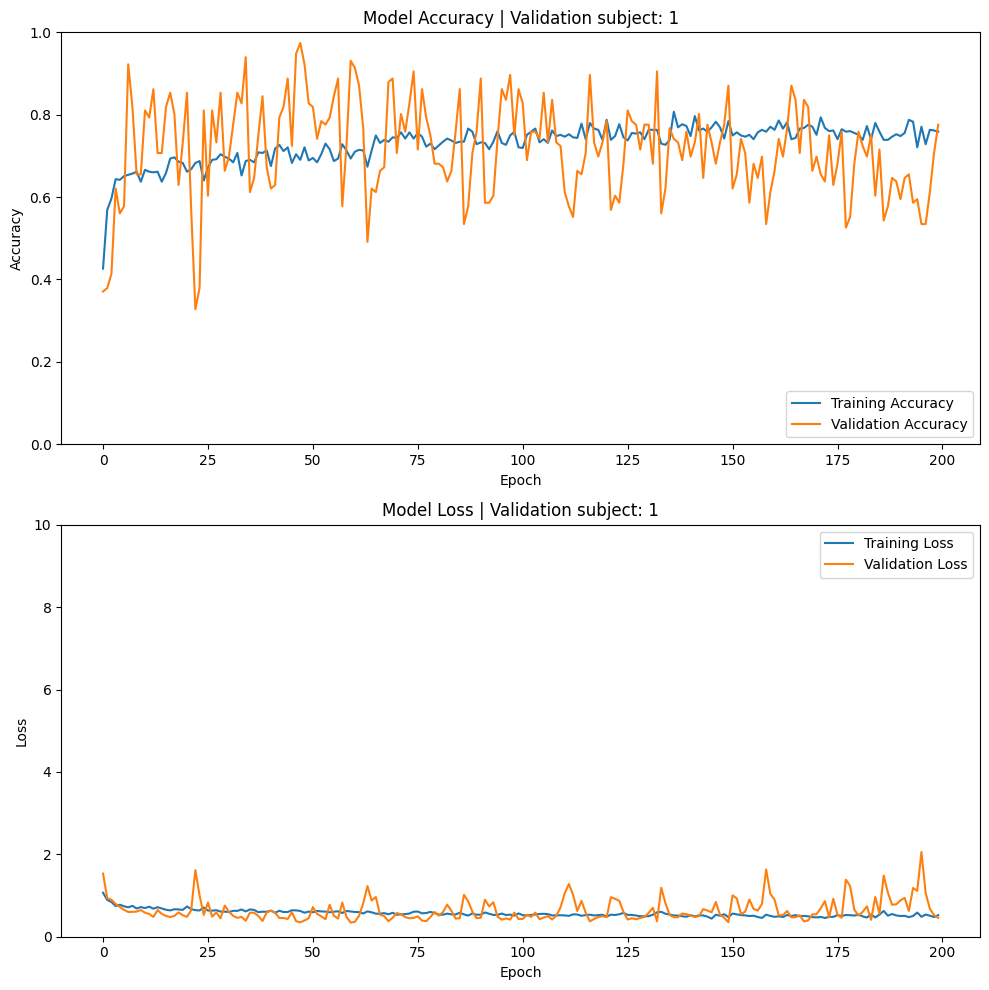

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix:
 [[36  1  0]
 [12 23  0]
 [ 0 13 31]]
Class-wise Accuracy: [0.97297297 0.65714286 0.70454545]
              precision    recall  f1-score   support

      Class0       0.75      0.97      0.85        37
      Class1       0.62      0.66      0.64        35
      Class2       1.00      0.70      0.83        44

    accuracy                           0.78       116
   macro avg       0.79      0.78      0.77       116
weighted avg       0.81      0.78      0.78       116



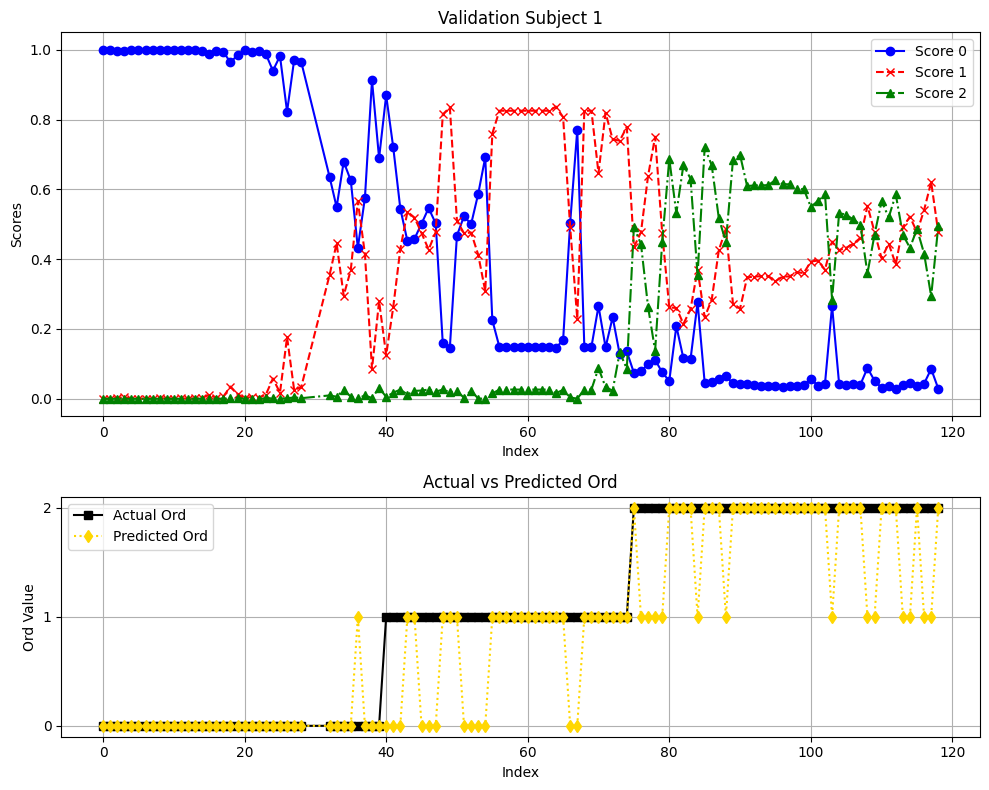

Subject test: 12
class name
Extremely Drowsy     62
Moderately Drowsy    31
Alert                26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5510 - loss: 1.4867 
Test Accuracy: 0.4789915978908539, Test Loss: 1.6307413578033447
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
Confusion Matrix:
 [[25  1  0]
 [23  8  0]
 [13 25 24]]
Class-wise Accuracy: [0.96153846 0.25806452 0.38709677]
              precision    recall  f1-score   support

      Class0       0.41      0.96      0.57        26
      Class1       0.24      0.26      0.25        31
      Class2       1.00      0.39      0.56        62

    accuracy                           0.48       119
   macro avg       0.55      0.54      0.46       119
weighted avg       0.67      0.48      0.48       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


C:\Users\Natchira\AppData\Local\Temp\ipykernel_22756\2306571147.py:201: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_ensemble_results = pd.concat([test_ensemble_results, new_data], axis=0)


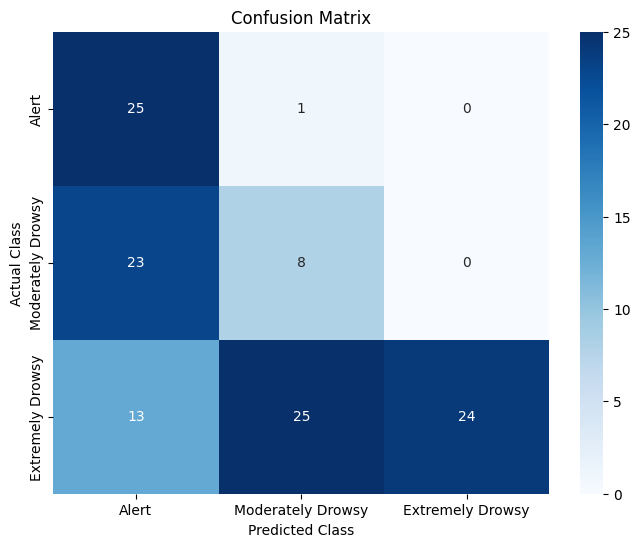

Subject test: 13
class name
Moderately Drowsy    65
Alert                28
Extremely Drowsy     26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3810 - loss: 7.1895 
Test Accuracy: 0.5462185144424438, Test Loss: 7.723071098327637
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
Confusion Matrix:
 [[ 0 28  0]
 [ 0 65  0]
 [ 0 26  0]]
Class-wise Accuracy: [0. 1. 0.]
              precision    recall  f1-score   support

      Class0       0.00      0.00      0.00        28
      Class1       0.55      1.00      0.71        65
      Class2       0.00      0.00      0.00        26

    accuracy                           0.55       119
   macro avg       0.18      0.33      0.24       119
weighted avg       0.30      0.55      0.39       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

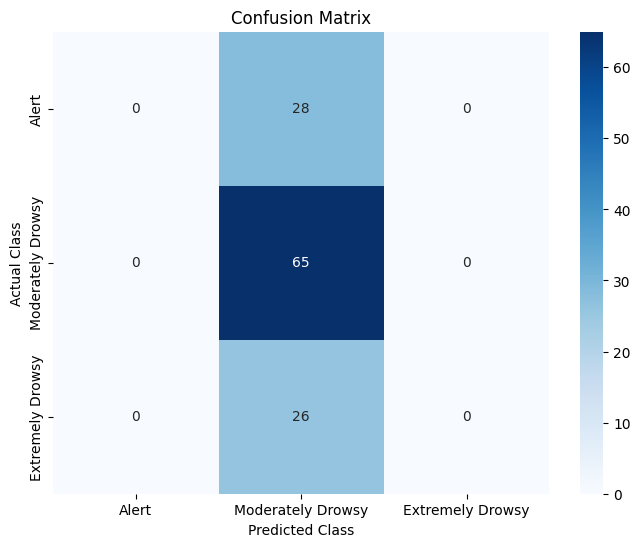

Fold #2
Validating on subject 2


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 73.00%
Test Accuracy: 0.7300000190734863, Test Loss: 0.60391765832901


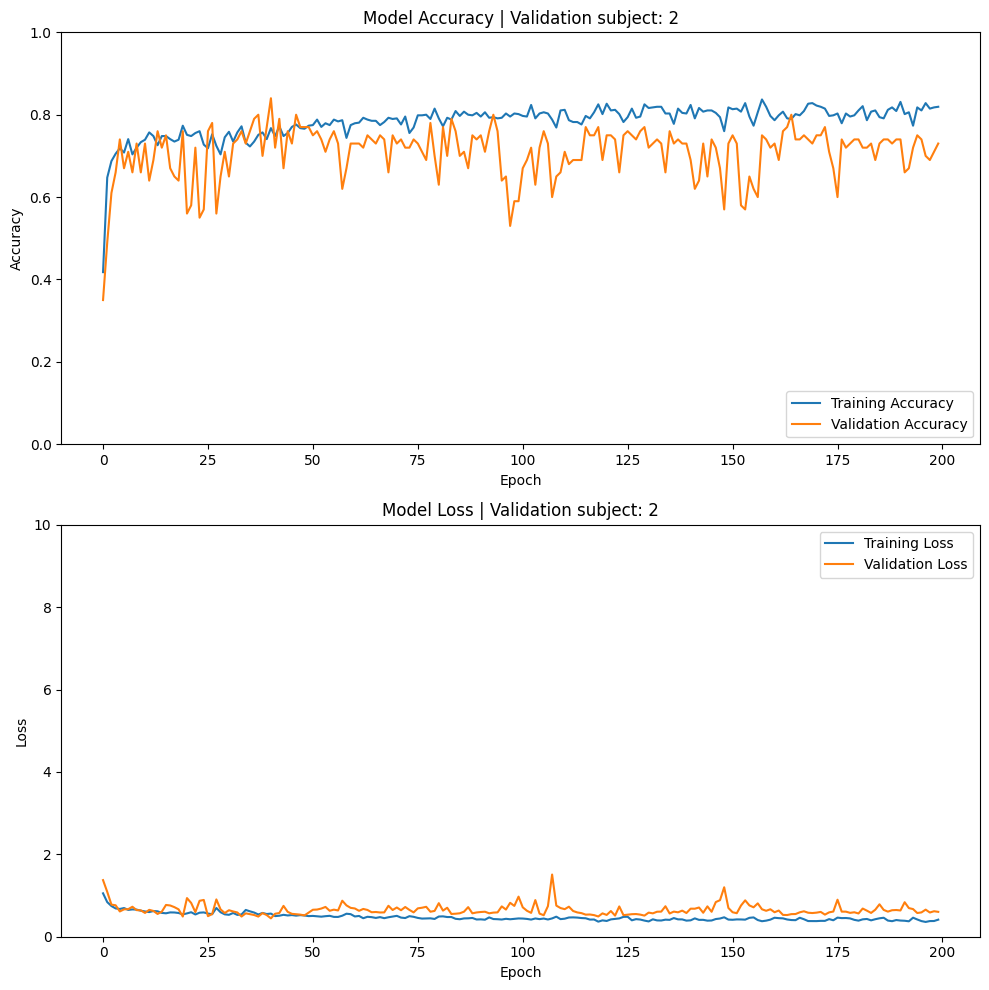

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Confusion Matrix:
 [[38 10  0]
 [ 0 15 14]
 [ 0  3 20]]
Class-wise Accuracy: [0.79166667 0.51724138 0.86956522]
              precision    recall  f1-score   support

      Class0       1.00      0.79      0.88        48
      Class1       0.54      0.52      0.53        29
      Class2       0.59      0.87      0.70        23

    accuracy                           0.73       100
   macro avg       0.71      0.73      0.70       100
weighted avg       0.77      0.73      0.74       100



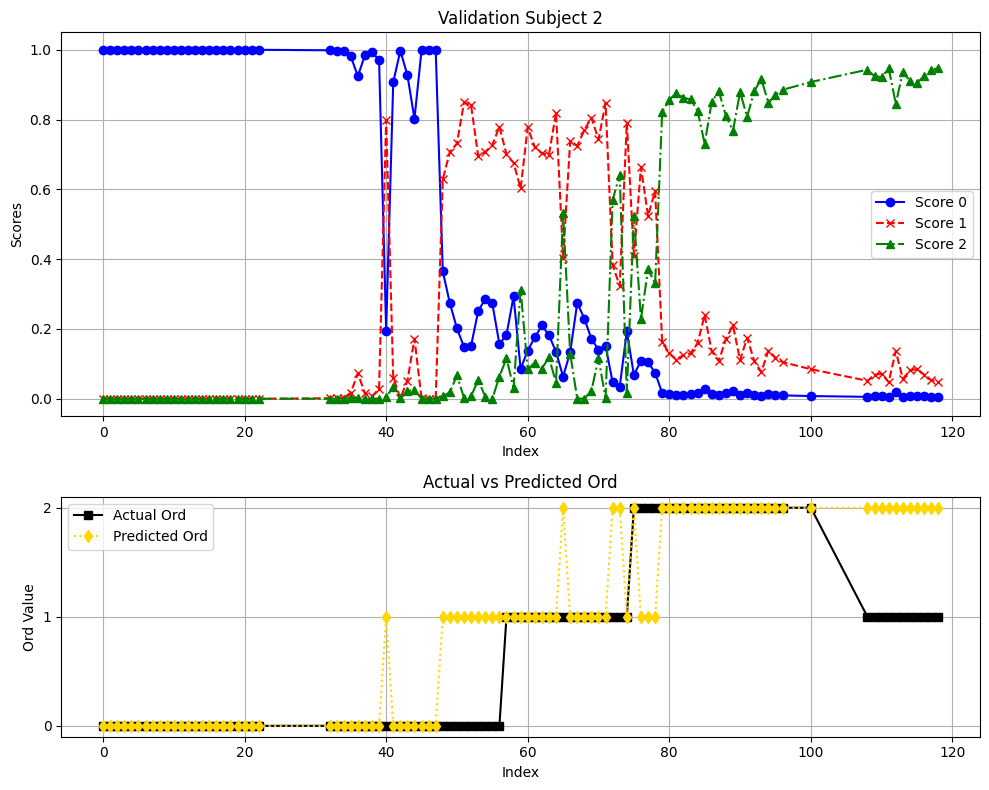

Subject test: 12
class name
Extremely Drowsy     62
Moderately Drowsy    31
Alert                26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5823 - loss: 1.6115 
Test Accuracy: 0.5546218752861023, Test Loss: 1.4625709056854248
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
Confusion Matrix:
 [[26  0  0]
 [23  8  0]
 [ 9 21 32]]
Class-wise Accuracy: [1.         0.25806452 0.51612903]
              precision    recall  f1-score   support

      Class0       0.45      1.00      0.62        26
      Class1       0.28      0.26      0.27        31
      Class2       1.00      0.52      0.68        62

    accuracy                           0.55       119
   macro avg       0.57      0.59      0.52       119
weighted avg       0.69      0.55      0.56       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step


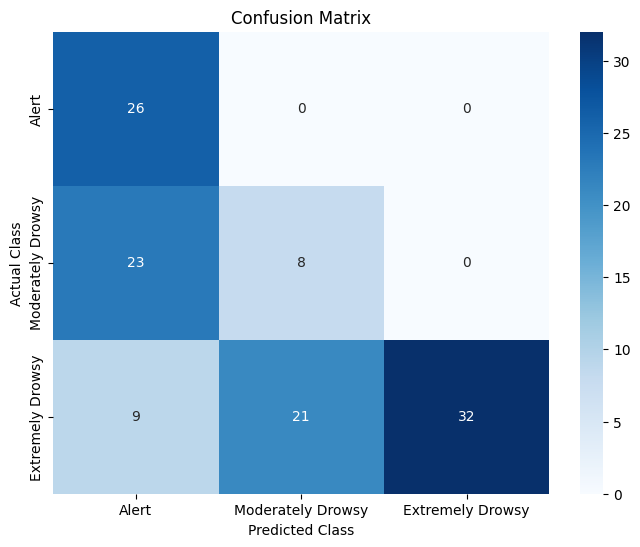

Subject test: 13
class name
Moderately Drowsy    65
Alert                28
Extremely Drowsy     26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6767 - loss: 4.5719 
Test Accuracy: 0.6890756487846375, Test Loss: 4.683112621307373
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
Confusion Matrix:
 [[28  0  0]
 [11 54  0]
 [ 0 26  0]]
Class-wise Accuracy: [1.         0.83076923 0.        ]
              precision    recall  f1-score   support

      Class0       0.72      1.00      0.84        28
      Class1       0.68      0.83      0.74        65
      Class2       0.00      0.00      0.00        26

    accuracy                           0.69       119
   macro avg       0.46      0.61      0.53       119
weighted avg       0.54      0.69      0.60       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

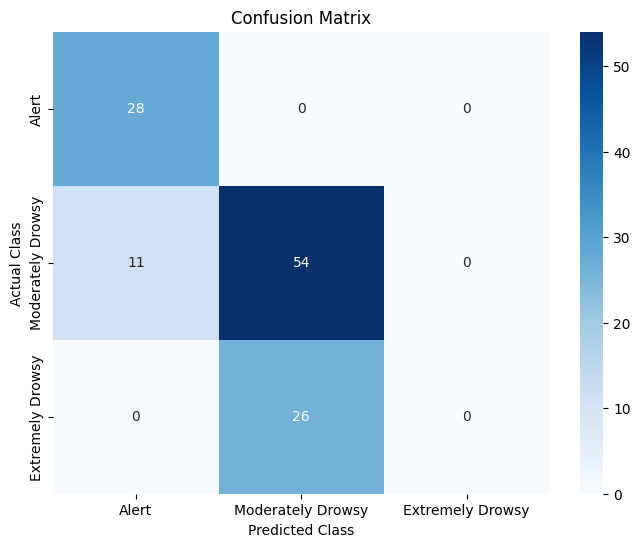

Fold #3
Validating on subject 3


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 36.94%
Test Accuracy: 0.36936935782432556, Test Loss: 1.2800875902175903


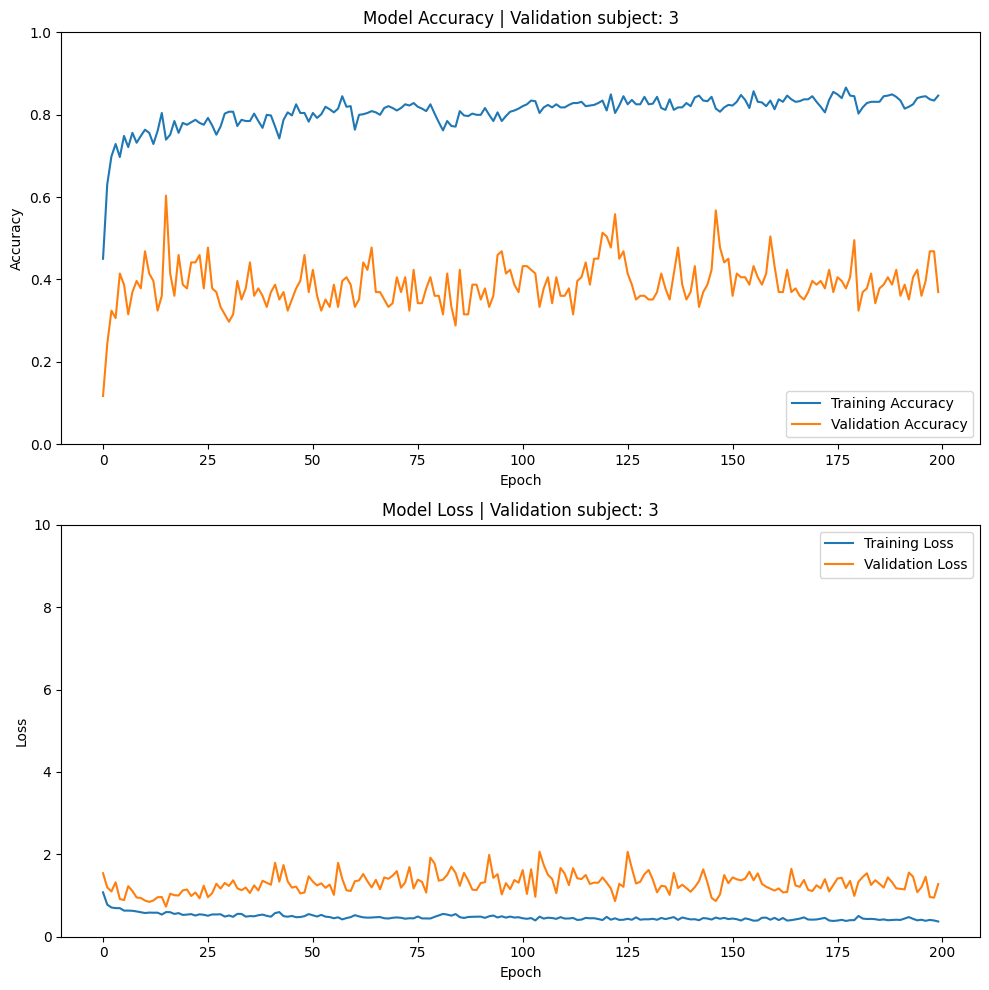

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Confusion Matrix:
 [[27 12  3]
 [ 9 10 46]
 [ 0  0  4]]
Class-wise Accuracy: [0.64285714 0.15384615 1.        ]
              precision    recall  f1-score   support

      Class0       0.75      0.64      0.69        42
      Class1       0.45      0.15      0.23        65
      Class2       0.08      1.00      0.14         4

    accuracy                           0.37       111
   macro avg       0.43      0.60      0.35       111
weighted avg       0.55      0.37      0.40       111



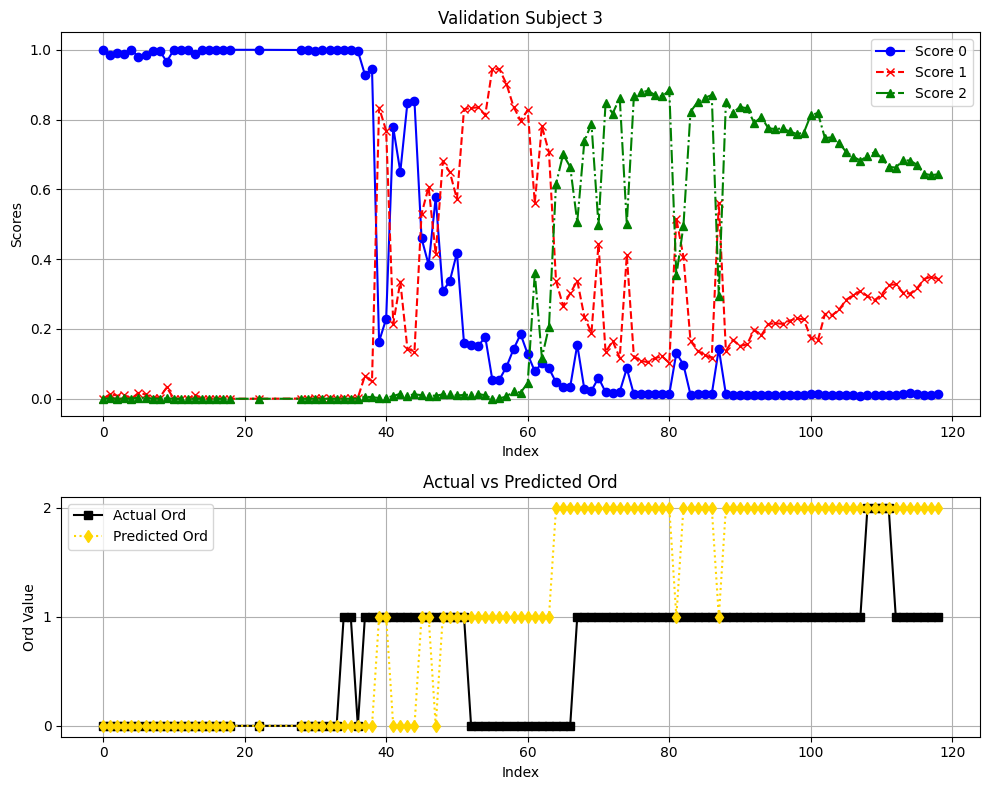

Subject test: 12
class name
Extremely Drowsy     62
Moderately Drowsy    31
Alert                26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5253 - loss: 2.5549 
Test Accuracy: 0.45378151535987854, Test Loss: 2.4819271564483643
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
Confusion Matrix:
 [[26  0  0]
 [23  8  0]
 [13 29 20]]
Class-wise Accuracy: [1.         0.25806452 0.32258065]
              precision    recall  f1-score   support

      Class0       0.42      1.00      0.59        26
      Class1       0.22      0.26      0.24        31
      Class2       1.00      0.32      0.49        62

    accuracy                           0.45       119
   macro avg       0.55      0.53      0.44       119
weighted avg       0.67      0.45      0.44       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step


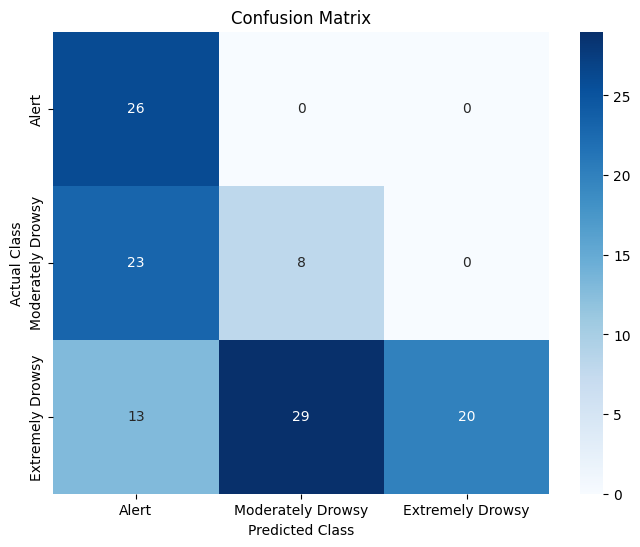

Subject test: 13
class name
Moderately Drowsy    65
Alert                28
Extremely Drowsy     26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6922 - loss: 1.2426 
Test Accuracy: 0.7226890921592712, Test Loss: 1.2606523036956787
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
Confusion Matrix:
 [[22  6  0]
 [ 1 64  0]
 [ 0 26  0]]
Class-wise Accuracy: [0.78571429 0.98461538 0.        ]
              precision    recall  f1-score   support

      Class0       0.96      0.79      0.86        28
      Class1       0.67      0.98      0.80        65
      Class2       0.00      0.00      0.00        26

    accuracy                           0.72       119
   macro avg       0.54      0.59      0.55       119
weighted avg       0.59      0.72      0.64       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

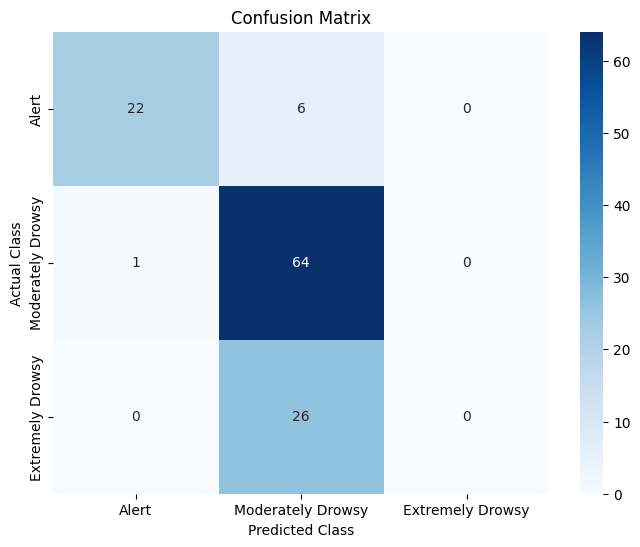

Fold #4
Validating on subject 4


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 54.87%
Test Accuracy: 0.5486725568771362, Test Loss: 1.3660340309143066


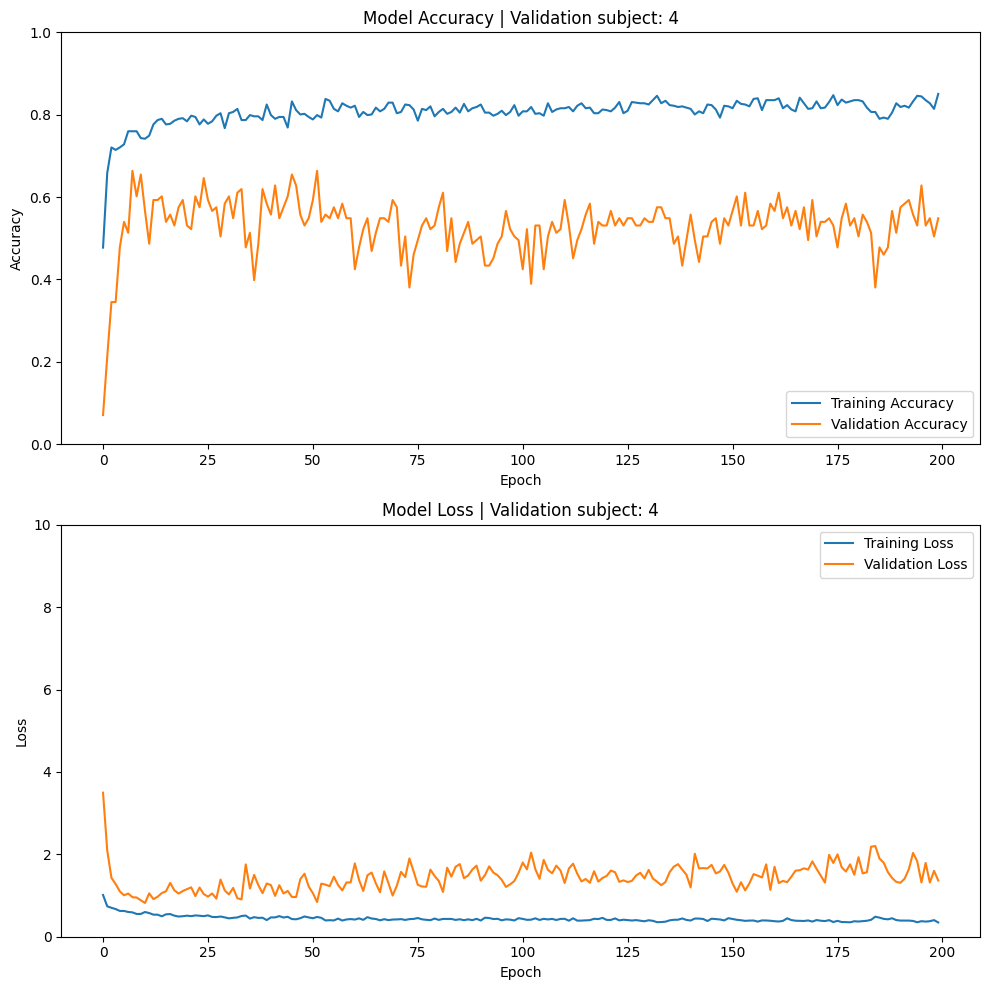

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Confusion Matrix:
 [[45 12 13]
 [13 17 13]
 [ 0  0  0]]
Class-wise Accuracy: [0.64285714 0.39534884        nan]
              precision    recall  f1-score   support

      Class0       0.78      0.64      0.70        70
      Class1       0.59      0.40      0.47        43
      Class2       0.00      0.00      0.00         0

    accuracy                           0.55       113
   macro avg       0.45      0.35      0.39       113
weighted avg       0.70      0.55      0.62       113



C:\Users\Natchira\AppData\Local\Temp\ipykernel_22756\2306571147.py:135: RuntimeWarning: invalid value encountered in divide
  class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:15

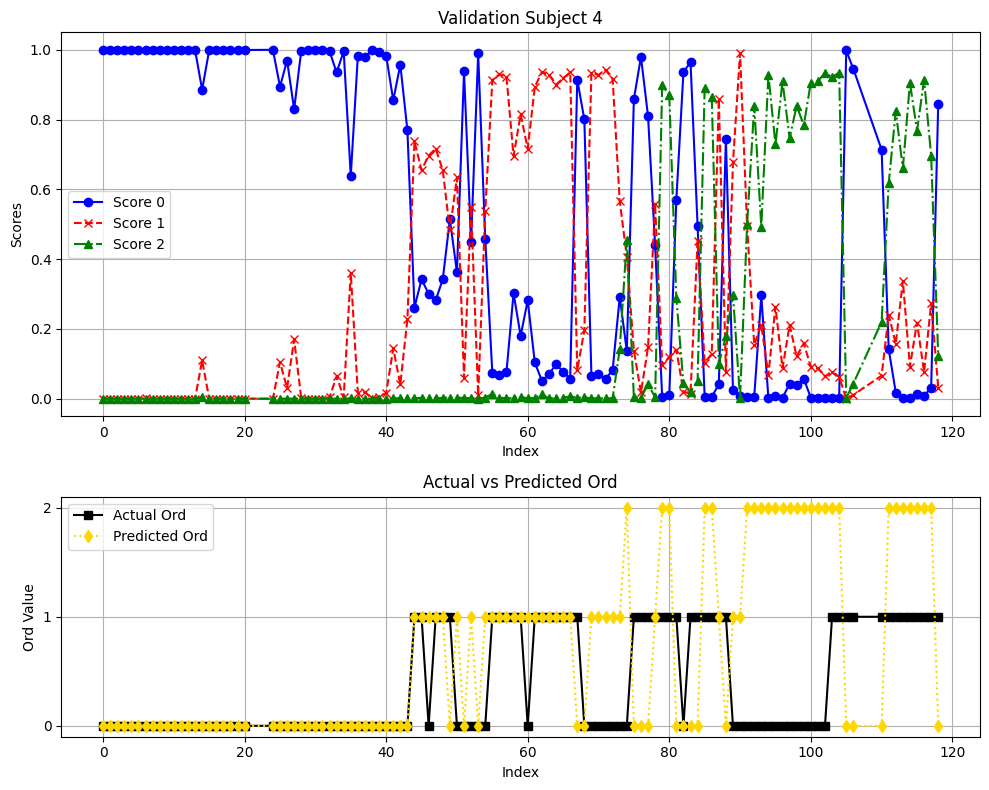

Subject test: 12
class name
Extremely Drowsy     62
Moderately Drowsy    31
Alert                26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5231 - loss: 2.3668 
Test Accuracy: 0.48739495873451233, Test Loss: 2.3000011444091797
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
Confusion Matrix:
 [[25  1  0]
 [25  6  0]
 [17 18 27]]
Class-wise Accuracy: [0.96153846 0.19354839 0.43548387]
              precision    recall  f1-score   support

      Class0       0.37      0.96      0.54        26
      Class1       0.24      0.19      0.21        31
      Class2       1.00      0.44      0.61        62

    accuracy                           0.49       119
   macro avg       0.54      0.53      0.45       119
weighted avg       0.67      0.49      0.49       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


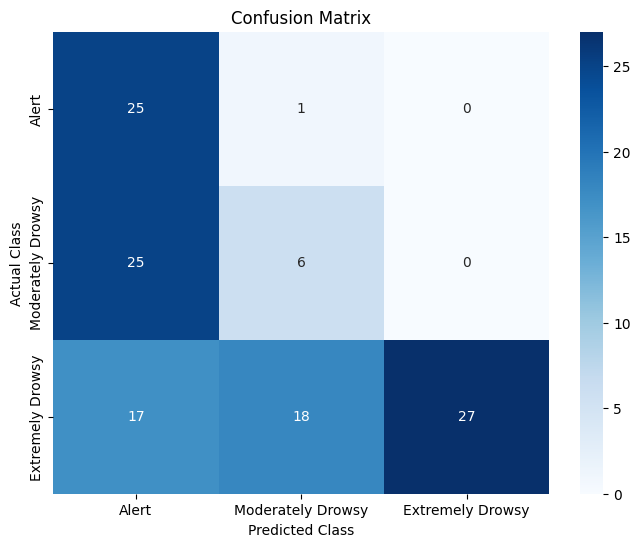

Subject test: 13
class name
Moderately Drowsy    65
Alert                28
Extremely Drowsy     26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3810 - loss: 3.0947 
Test Accuracy: 0.5462185144424438, Test Loss: 2.5852649211883545
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
Confusion Matrix:
 [[ 0 28  0]
 [ 0 65  0]
 [ 3 23  0]]
Class-wise Accuracy: [0. 1. 0.]
              precision    recall  f1-score   support

      Class0       0.00      0.00      0.00        28
      Class1       0.56      1.00      0.72        65
      Class2       0.00      0.00      0.00        26

    accuracy                           0.55       119
   macro avg       0.19      0.33      0.24       119
weighted avg       0.31      0.55      0.39       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

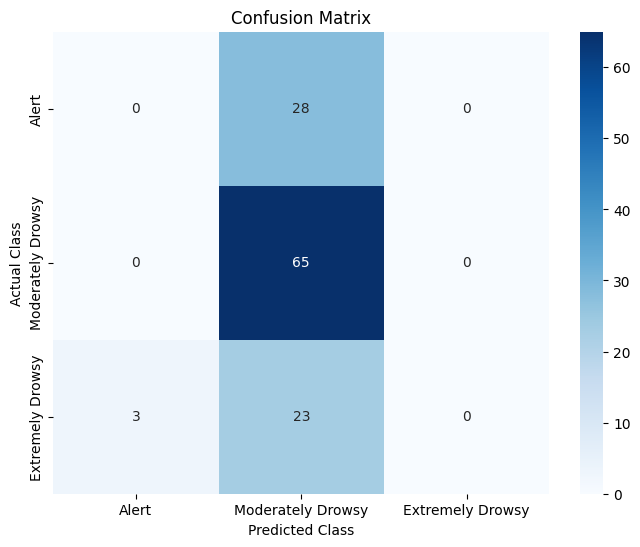

Fold #5
Validating on subject 5


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 89.62%
Test Accuracy: 0.8962264060974121, Test Loss: 0.29401594400405884


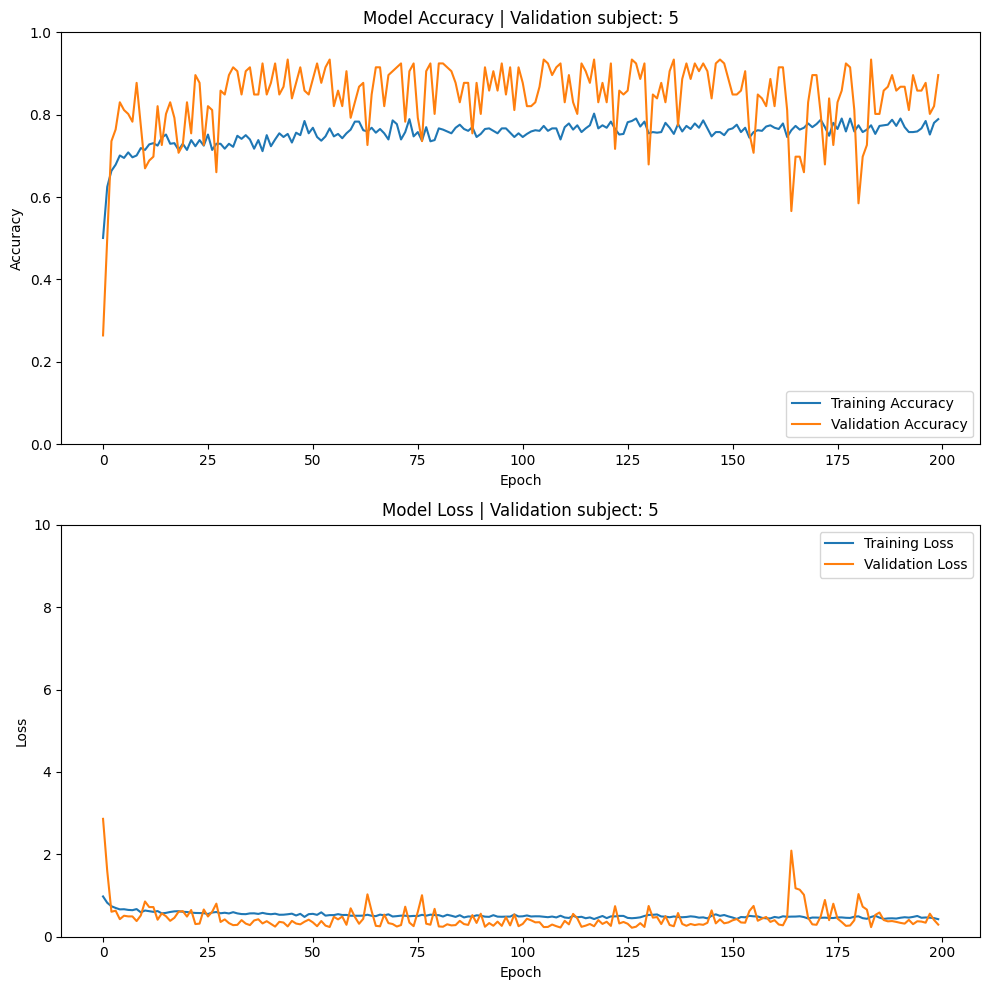

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix:
 [[95  4]
 [ 7  0]]
Class-wise Accuracy: [0.95959596 0.        ]
              precision    recall  f1-score   support

      Class0       0.93      0.96      0.95        99
      Class1       0.00      0.00      0.00         7

    accuracy                           0.90       106
   macro avg       0.47      0.48      0.47       106
weighted avg       0.87      0.90      0.88       106



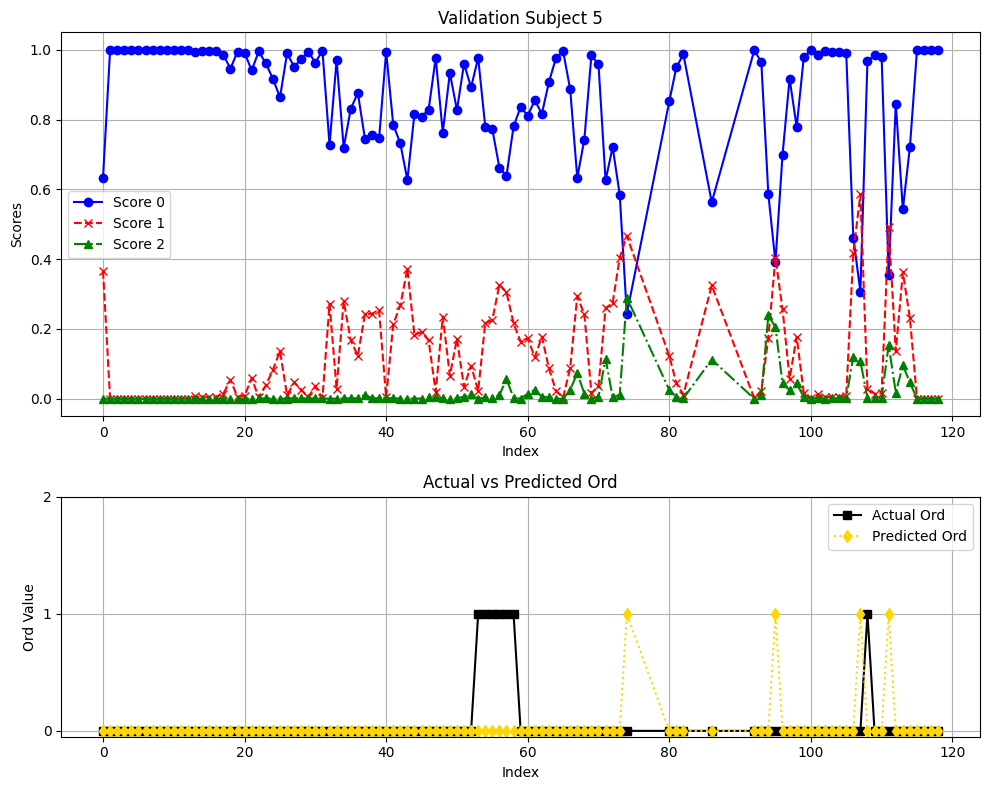

Subject test: 12
class name
Extremely Drowsy     62
Moderately Drowsy    31
Alert                26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5156 - loss: 1.4672 
Test Accuracy: 0.4789915978908539, Test Loss: 1.4593408107757568
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
 [[26  0  0]
 [28  3  0]
 [11 23 28]]
Class-wise Accuracy: [1.         0.09677419 0.4516129 ]
              precision    recall  f1-score   support

      Class0       0.40      1.00      0.57        26
      Class1       0.12      0.10      0.11        31
      Class2       1.00      0.45      0.62        62

    accuracy                           0.48       119
   macro avg       0.51      0.52      0.43       119
weighted avg       0.64      0.48      0.48       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


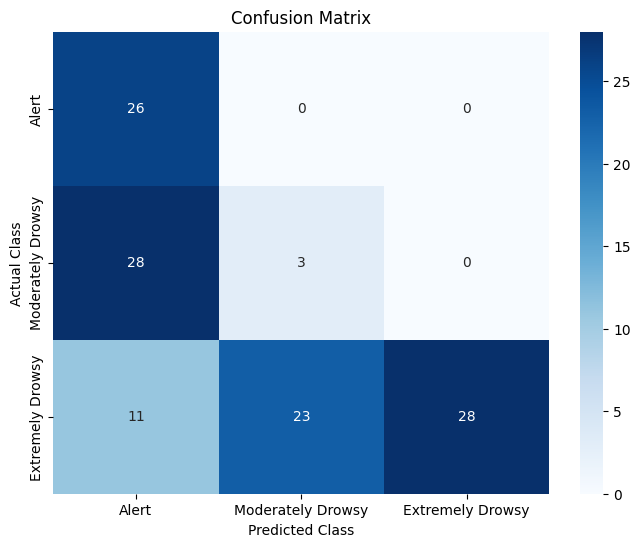

Subject test: 13
class name
Moderately Drowsy    65
Alert                28
Extremely Drowsy     26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4106 - loss: 7.1345 
Test Accuracy: 0.5630252361297607, Test Loss: 5.801671504974365
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
 [[ 2 26  0]
 [ 0 65  0]
 [ 0 26  0]]
Class-wise Accuracy: [0.07142857 1.         0.        ]
              precision    recall  f1-score   support

      Class0       1.00      0.07      0.13        28
      Class1       0.56      1.00      0.71        65
      Class2       0.00      0.00      0.00        26

    accuracy                           0.56       119
   macro avg       0.52      0.36      0.28       119
weighted avg       0.54      0.56      0.42       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

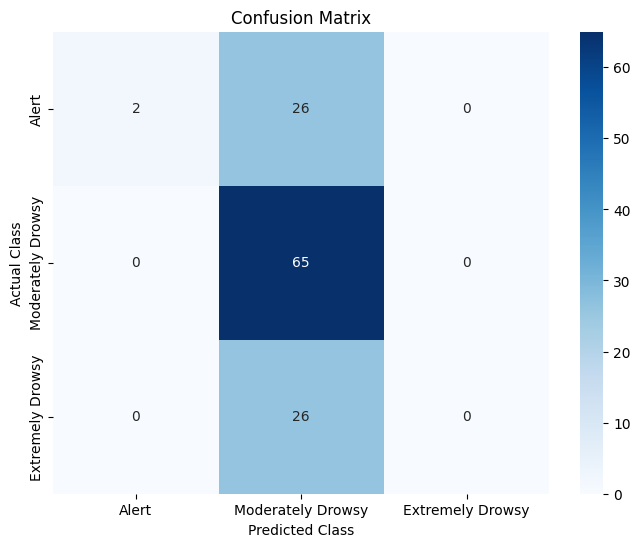

Fold #6
Validating on subject 6


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 87.27%
Test Accuracy: 0.8727272748947144, Test Loss: 0.36155056953430176


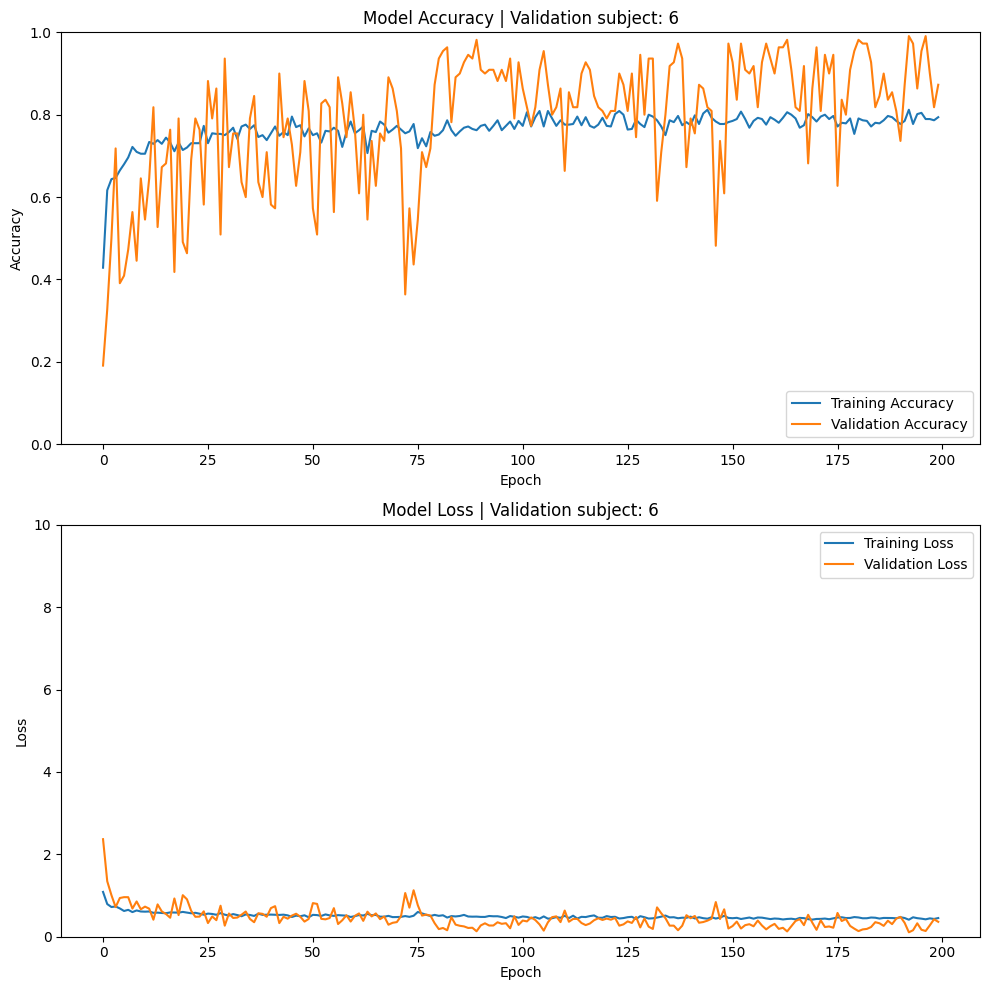

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix:
 [[96 14]
 [ 0  0]]
Class-wise Accuracy: [0.87272727        nan]
              precision    recall  f1-score   support

      Class0       1.00      0.87      0.93       110
      Class1       0.00      0.00      0.00         0

    accuracy                           0.87       110
   macro avg       0.50      0.44      0.47       110
weighted avg       1.00      0.87      0.93       110



C:\Users\Natchira\AppData\Local\Temp\ipykernel_22756\2306571147.py:135: RuntimeWarning: invalid value encountered in divide
  class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:15

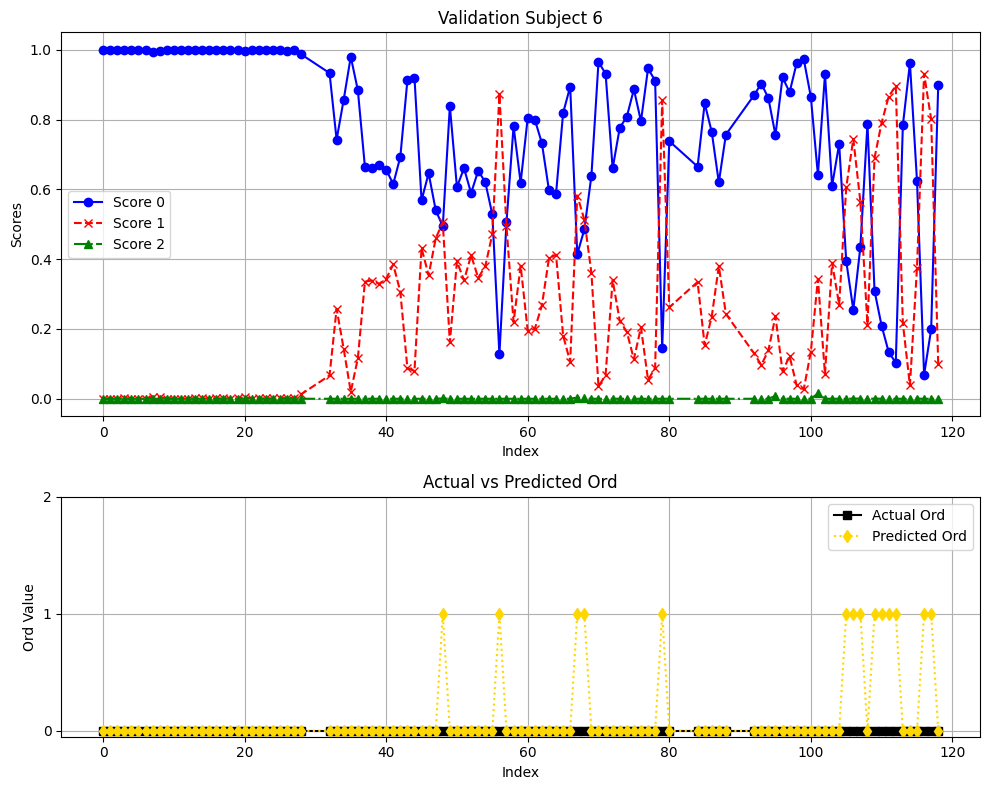

Subject test: 12
class name
Extremely Drowsy     62
Moderately Drowsy    31
Alert                26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5996 - loss: 1.9218 
Test Accuracy: 0.5798319578170776, Test Loss: 1.8530070781707764
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
 [[26  0  0]
 [22  9  0]
 [12 16 34]]
Class-wise Accuracy: [1.         0.29032258 0.5483871 ]
              precision    recall  f1-score   support

      Class0       0.43      1.00      0.60        26
      Class1       0.36      0.29      0.32        31
      Class2       1.00      0.55      0.71        62

    accuracy                           0.58       119
   macro avg       0.60      0.61      0.54       119
weighted avg       0.71      0.58      0.58       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


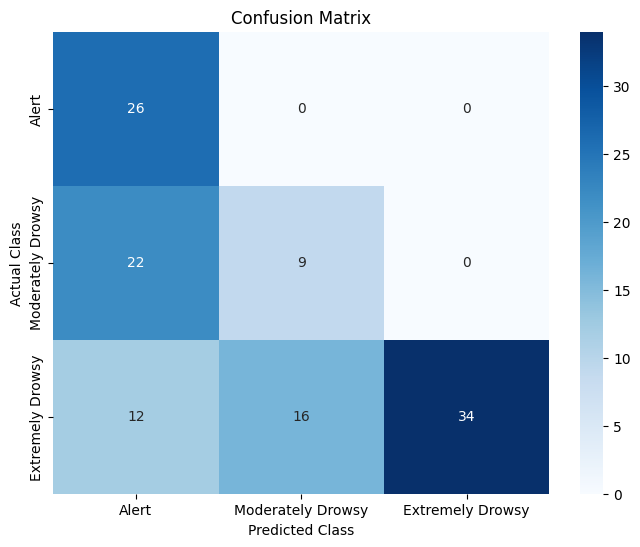

Subject test: 13
class name
Moderately Drowsy    65
Alert                28
Extremely Drowsy     26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4106 - loss: 5.1262 
Test Accuracy: 0.5630252361297607, Test Loss: 3.9333157539367676
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
Confusion Matrix:
 [[ 2 26  0]
 [ 0 65  0]
 [ 0 26  0]]
Class-wise Accuracy: [0.07142857 1.         0.        ]
              precision    recall  f1-score   support

      Class0       1.00      0.07      0.13        28
      Class1       0.56      1.00      0.71        65
      Class2       0.00      0.00      0.00        26

    accuracy                           0.56       119
   macro avg       0.52      0.36      0.28       119
weighted avg       0.54      0.56      0.42       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

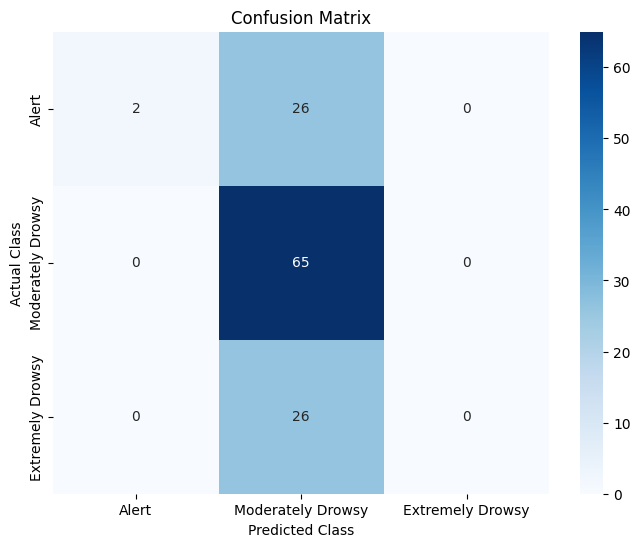

Fold #7
Validating on subject 7


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 84.03%
Test Accuracy: 0.8403361439704895, Test Loss: 1.1492568254470825


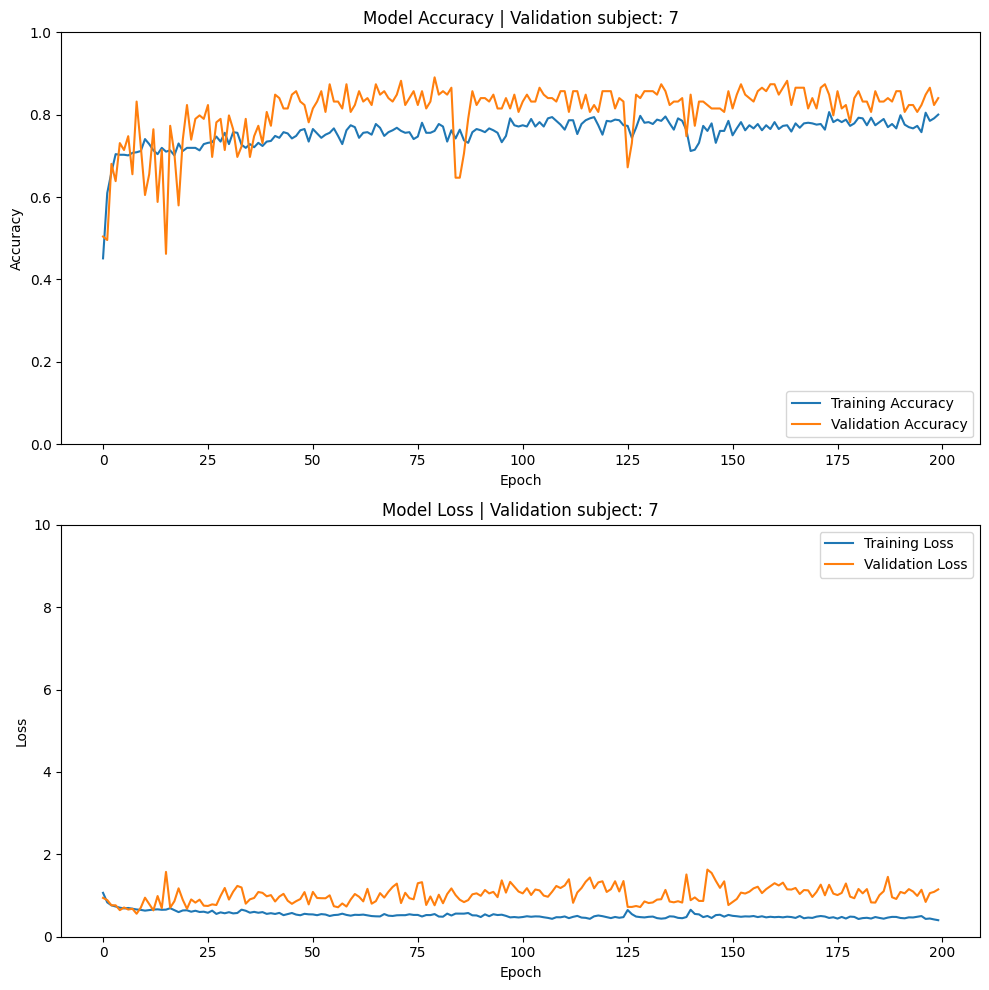

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Confusion Matrix:
 [[30  6  0]
 [ 6 68  0]
 [ 0  7  2]]
Class-wise Accuracy: [0.83333333 0.91891892 0.22222222]
              precision    recall  f1-score   support

      Class0       0.83      0.83      0.83        36
      Class1       0.84      0.92      0.88        74
      Class2       1.00      0.22      0.36         9

    accuracy                           0.84       119
   macro avg       0.89      0.66      0.69       119
weighted avg       0.85      0.84      0.83       119



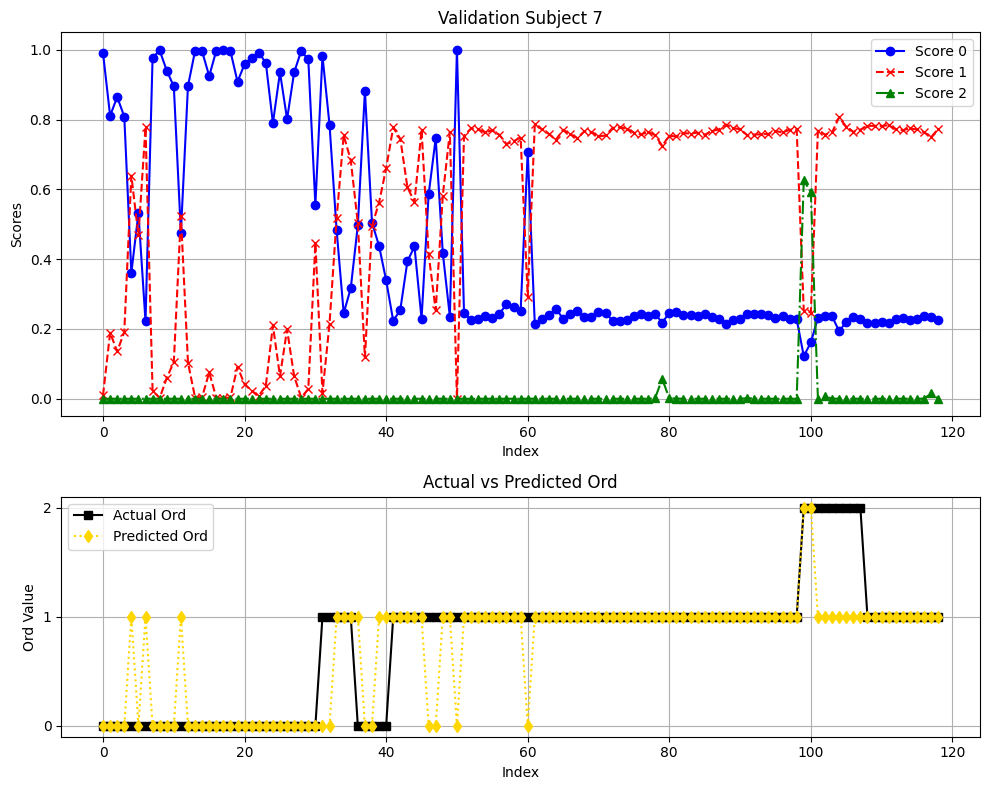

Subject test: 12
class name
Extremely Drowsy     62
Moderately Drowsy    31
Alert                26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4725 - loss: 2.9484 
Test Accuracy: 0.4285714328289032, Test Loss: 2.957631826400757
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
Confusion Matrix:
 [[25  1  0]
 [29  2  0]
 [17 21 24]]
Class-wise Accuracy: [0.96153846 0.06451613 0.38709677]
              precision    recall  f1-score   support

      Class0       0.35      0.96      0.52        26
      Class1       0.08      0.06      0.07        31
      Class2       1.00      0.39      0.56        62

    accuracy                           0.43       119
   macro avg       0.48      0.47      0.38       119
weighted avg       0.62      0.43      0.42       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


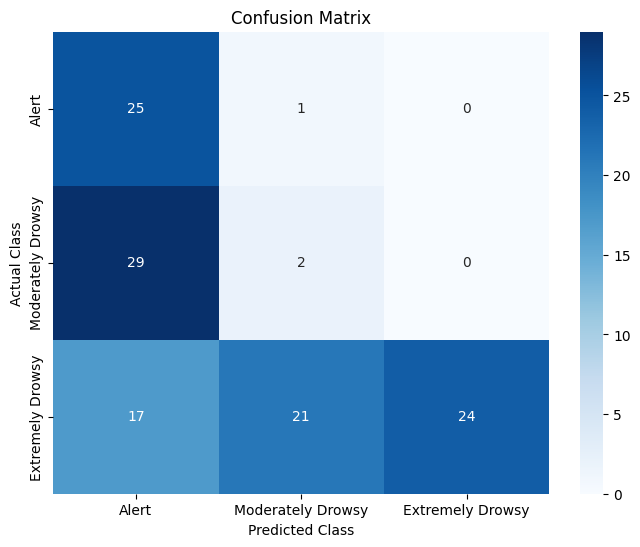

Subject test: 13
class name
Moderately Drowsy    65
Alert                28
Extremely Drowsy     26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3810 - loss: 4.0259 
Test Accuracy: 0.5462185144424438, Test Loss: 4.022607803344727
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
Confusion Matrix:
 [[ 0 28  0]
 [ 0 65  0]
 [ 2 24  0]]
Class-wise Accuracy: [0. 1. 0.]
              precision    recall  f1-score   support

      Class0       0.00      0.00      0.00        28
      Class1       0.56      1.00      0.71        65
      Class2       0.00      0.00      0.00        26

    accuracy                           0.55       119
   macro avg       0.19      0.33      0.24       119
weighted avg       0.30      0.55      0.39       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

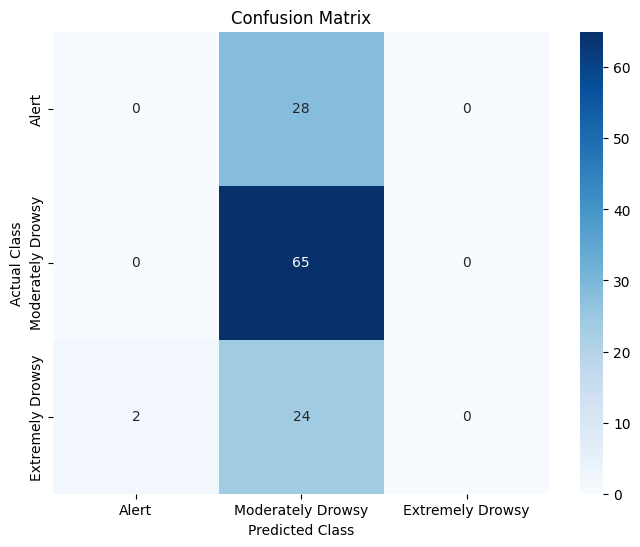

In [36]:
unique_subjects = combined_data_allcases['subject'].unique()
results = pd.DataFrame(columns=['subject_validation', 'accuracy'])
test_ensemble_results = pd.DataFrame(columns=['subject_test', 'accuracy', 'loss'])

fold = 0

for subject in unique_subjects:
    fold+=1
    print(f'Fold #{fold}')
    print(f"Validating on subject {subject}")

    # Train-Validation Splitting
    train = combined_data_allcases[combined_data_allcases['subject'] != subject]
    validation = combined_data_allcases[combined_data_allcases['subject'] == subject]

    # Extract features and labels
    X_train = train.loc[:, ~combined_data_allcases.columns.isin(excluded_columns)]
    X_validation = validation.loc[:, ~combined_data_allcases.columns.isin(excluded_columns)]
    y_train = train['ORD class']
    y_validation = validation['ORD class']

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    X_train = X_train.sample(frac=1, random_state=seed)
    y_train = y_train.loc[X_train.index] # Use the index of the shuffled X_train to reorder y_train

    numInputlayers = len(X_train.columns)

    # Scaling
    scaler = ColumnTransformer([
        ('passthrough', 'passthrough', columns_not_to_scale)
    ], remainder=StandardScaler())

    X_train_scaled = scaler.fit_transform(X_train)

    transformed_columns = columns_not_to_scale + [col for col in X_train.columns if col not in columns_not_to_scale]

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=transformed_columns)

    X_train_scaled = X_train_scaled[X_train.columns]

    X_validation_scaled = scaler.transform(X_validation)
    X_validation_scaled = pd.DataFrame(X_validation_scaled, columns=transformed_columns)
    X_validation_scaled = X_validation_scaled[X_validation.columns]

    # Encoding
    encoder = OneHotEncoder(categories=[ord_type], sparse_output=False)
    encoder.fit(pd.DataFrame(y_train))
    y_train_encoded = encoder.transform(pd.DataFrame(y_train))
    y_validation_encoded = encoder.transform(pd.DataFrame(y_validation))

    ###################################

    # set seed
    np.random.seed(seed)
    python_random.seed(seed)
    tf.random.set_seed(seed)

    # Call model architecture from function

    optimal_input_dim = len(X_train.columns)
    optimal_num_classes = len(ord_type) 

    model = create_model(input_dim=optimal_input_dim, num_classes=optimal_num_classes)
    
    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

    # Model Fit
    history = model.fit(X_train_scaled, y_train_encoded, 
              verbose=0,
              class_weight=class_weights_dict,
              epochs=200, batch_size=32, 
              validation_data=(X_validation_scaled, y_validation_encoded)
              )
    
    ###################################

    # Model Evaluation

    ## 1) Store accuracy in the dataframe 'results'
    test_loss, test_acc = model.evaluate(X_validation_scaled, y_validation_encoded, verbose=0)
                            
    print(f"Accuracy: {test_acc*100:.2f}%")
    new_data = pd.DataFrame({'subject_validation': [subject], 'accuracy': [test_acc]})
    results = pd.concat([results, new_data], axis=0)

    print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

    ## 2) Plot Trend of Training, Validation Accuracy
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 Rows, 1 Column

    # Plot Training and Validation Accuracy
    axs[0].plot(history.history['accuracy'], label='Training Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title(f'Model Accuracy | Validation subject: {subject}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_ylim([0, 1])
    axs[0].legend(loc='lower right')

    # Plot Training and Validation Loss
    axs[1].plot(history.history['loss'], label='Training Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title(f'Model Loss | Validation subject: {subject}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_ylim([0, 10])
    axs[1].legend(loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.show()

    ## 4) Print Confusion Matrix, Accuracy Report
    ### Predict the test set
    predictions = model.predict(X_validation_scaled)
    predicted_classes = np.argmax(predictions, axis=1)

    ### True classes (convert from one-hot if necessary)
    true_classes = np.argmax(y_validation_encoded, axis=1)  # Make sure y_encoded is not class indices

    unique_classes = np.unique(np.concatenate((predicted_classes, true_classes)))
    max_class_label = unique_classes.max()
    class_labels = list(range(max_class_label + 1))

    ### Confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes, labels=class_labels)
    print("Confusion Matrix:\n", conf_matrix)

    ### Class-wise accuracy
    class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    print("Class-wise Accuracy:", class_wise_accuracy)

    ### Detailed classification report
    target_names = [f'Class{i}' for i in class_labels]
    report = classification_report(true_classes, predicted_classes, labels=class_labels, target_names=target_names)

    print(report)

    ## 5) Probability Trend
    new_y = pd.DataFrame()
    new_y['ord'] = (y_validation-1)
    new_y['score0'] = predictions[:, 0]
    new_y['score1'] = predictions[:, 1]
    new_y['score2'] = predictions[:, 2]
    new_y['predicted_ord'] = (predicted_classes)

    probability_plot(new_y, subject)

    #---------------------------------------------------------------------------------------------------------

# Test the model on test cases

    for subject_test_order in range(len(subject_test_list)):
        subject_test = subject_test_list[subject_test_order]
        
        # Create combined dataframe to store data of 1 subject_test
        ECG_features_test_df = ECG_dataframe(subject_test_order, ECG_features_testcases)

        EEG_features_test_df_list = EEG_dataframe_list(subject_test_order, EEG_features_testcases, channelList_testcases)

        EEG_features_test_df = pd.DataFrame()

        for EEG_channel in EEG_channel_list:
            EEG_features_append = EEG_features_test_df_list[EEG_channel-1].copy()
            EEG_features_append.columns = [f'{col}_{EEG_channel}' for col in EEG_features_append.columns]
            EEG_features_test_df = pd.concat([EEG_features_test_df, EEG_features_append], axis=1)

        ord_epoch_test = ord_dataframe(subject_test_order, ord_60min_testcases, numClasses)

        print(f'Subject test: {subject_test}')
        print(ord_epoch_test['class name'].value_counts())

        combined_test_data = combined_dataframe(EEG_features_test_df, ECG_features_test_df, ord_epoch_test)

        combined_test_data.insert(1, 'Initial_KSS', initial_kss[subject_test-1])
        combined_test_data.insert(0, 'subject', subject_test)

        combined_test_data = combined_test_data.dropna()

        # combined_test_data.insert(0, 'subject_test', subject_test)

        # Prepare X_test, y_test of 1 subject_test
        X_test = combined_test_data.loc[:, ~combined_test_data.columns.isin(excluded_columns)]
        y_test = combined_test_data['ORD class']

        # Scaling
        X_test_scaled = scaler.transform(X_test)

        # Encoding labels
        y_test_encoded = encoder.transform(pd.DataFrame(y_test))

        # Model Evaluation
        test_loss, test_acc = model.evaluate(X_test_scaled, y_test_encoded)
        
        new_data = pd.DataFrame({'subject_test': [subject_test], 'accuracy': [test_acc], 'loss': [test_loss]})
        test_ensemble_results = pd.concat([test_ensemble_results, new_data], axis=0)

        print(f'Test Accuracy: {test_acc}, Test Loss: {test_loss}')

        # Print Confusion Matrix, Accuracy Report
        ### Predict the test set
        predictions = model.predict(X_test_scaled)
        predicted_classes = np.argmax(predictions, axis=1)

        ### True classes (convert from one-hot if necessary)
        true_classes = np.argmax(y_test_encoded, axis=1)  # Make sure y_encoded is not class indices

        unique_classes = np.unique(np.concatenate((predicted_classes, true_classes)))
        max_class_label = unique_classes.max()
        class_labels = list(range(max_class_label + 1))

        ### Confusion matrix
        conf_matrix = confusion_matrix(true_classes, predicted_classes, labels=class_labels)
        print("Confusion Matrix:\n", conf_matrix)

        ### Class-wise accuracy
        class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
        print("Class-wise Accuracy:", class_wise_accuracy)

        ### Detailed classification report
        target_names = [f'Class{i}' for i in class_labels]
        report = classification_report(true_classes, predicted_classes, labels=class_labels, target_names=target_names)

        print(report)

        y_test_hat = model.predict(X_test_scaled)
        y_test_hat_classes = np.argmax(y_test_hat, axis=1)
        y_test_compare = y_test-1

        # Compute the confusion matrix
        cm = confusion_matrix(y_test_compare, y_test_hat_classes)
        def plot_confusion_matrix(cm, class_names):
            """
            Plots a confusion matrix using Seaborn's heatmap().
            """
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
            plt.title('Confusion Matrix')
            plt.ylabel('Actual Class')
            plt.xlabel('Predicted Class')
            plt.show()

        if numClasses == 3:
            class_names = ['Alert', 'Moderately Drowsy', 'Extremely Drowsy']
        elif numClasses == 2:
            class_names = ['Alert', 'Drowsy']
        # Assuming 'class_names' is a list of your class names, such as class_names = ['Class1', 'Class2', 'Class3']
        plot_confusion_matrix(cm, class_names)

    #---------------------------------------------------------------------------------------------------------


In [37]:
# Average the results
average_accuracy = results['accuracy'].mean()
print(f"Average Accuracy: {average_accuracy*100:.2f}%")

average_ensemble_accuracy = test_ensemble_results['accuracy'].mean()
print(f"Average Ensemble Accuracy: {average_ensemble_accuracy*100:.2f}%")

Average Accuracy: 71.90%
Average Ensemble Accuracy: 54.56%


In [38]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,757 (6.87 KB)

 Trainable params: 561 (2.19 KB)

 Non-trainable params: 72 (288.00 B)

 Optimizer params: 1,124 (4.39 KB)

## **5. Model Training on the entire training set**

In [39]:
# Assume 'combined_data_allcases' is your full dataset and 'excluded_columns' are non-feature columns
X = combined_data_allcases.loc[:, ~combined_data_allcases.columns.isin(excluded_columns)]
y = combined_data_allcases['ORD class']

# # Splitting the dataset into training and testing sets
# X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Scaling features
scaler = ColumnTransformer([
    ('passthrough', 'passthrough', columns_not_to_scale),
], remainder=StandardScaler())

X_scaled = scaler.fit_transform(X)

# Encoding labels
encoder = OneHotEncoder(categories=[ord_type], sparse_output=False)
encoder.fit(pd.DataFrame(y))  # Fit encoder on the full training set
y_encoded = encoder.transform(pd.DataFrame(y))

In [40]:
# set seed
np.random.seed(seed)
python_random.seed(seed)
tf.random.set_seed(seed)

# Call model architecture from function

optimal_input_dim = len(X.columns)
optimal_num_classes = len(ord_type) 

final_model = create_model(input_dim=optimal_input_dim, num_classes=optimal_num_classes)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

    # Model Fit
final_history = final_model.fit(X_scaled, y_encoded, 
            #   verbose=0,
              class_weight=class_weights_dict,
              epochs=200, batch_size=32, 
              # validation_data=(X_validation_scaled, y_validation_encoded)
              )

c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4071 - loss: 1.1748
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.6612 - loss: 0.7867
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.6614 - loss: 0.6992
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.6969 - loss: 0.6931
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.7092 - loss: 0.6751
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6998 - loss: 0.6977
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7528 - loss: 0.6022 
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.7352 - loss: 0.6321
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.7271 - loss: 0.5987
Epoch 10/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.7200 - loss: 0.6057
Epoch 11/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.7294 - loss: 0.6095
Epoch 12/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8

## **6. Testing set: Import Data**

In [41]:
for subject_order in range(len(subject_test_list)):
    subject_test = subject_test_list[subject_order]
    print(subject_test)

12
13


In [42]:
# create a list of features (list containing data from each subject in subject_list)

EEG_features_testcases = []
ECG_features_testcases = []
ord_60min_testcases = []
channelList_testcases = []

for subject_test in subject_test_list:
    ECG_features, EEG_features, ord_60min, channelList = load_subject_data(subject_test)
    EEG_features_testcases.append(EEG_features)
    ECG_features_testcases.append(ECG_features)
    ord_60min_testcases.append(ord_60min)
    channelList_testcases.append(channelList)


Subject test: 12
class name
Extremely Drowsy     62
Moderately Drowsy    31
Alert                26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5584 - loss: 2.6049  
Test Accuracy: 0.5210084319114685, Test Loss: 2.3874096870422363
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix:
 [[26  0  0]
 [23  8  0]
 [20 14 28]]
Class-wise Accuracy: [1.         0.25806452 0.4516129 ]
              precision    recall  f1-score   support

      Class0       0.38      1.00      0.55        26
      Class1       0.36      0.26      0.30        31
      Class2       1.00      0.45      0.62        62

    accuracy                           0.52       119
   macro avg       0.58      0.57      0.49       119
weighted avg       0.70      0.52      0.52       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step


C:\Users\Natchira\AppData\Local\Temp\ipykernel_22756\3298502898.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_results = pd.concat([test_results, new_data], axis=0)


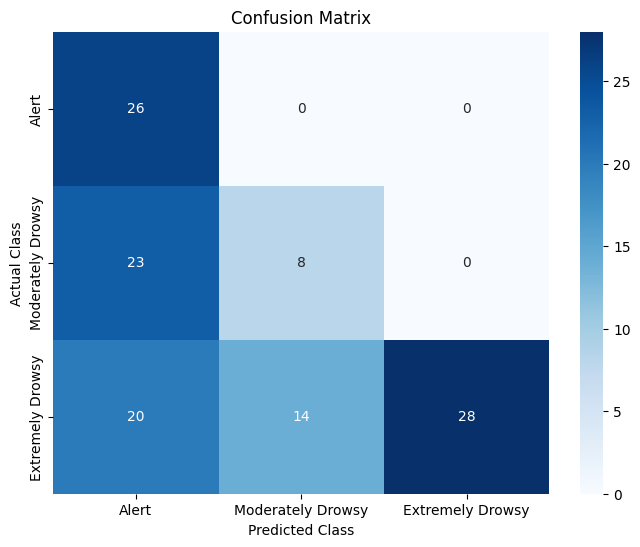

Subject test: 13
class name
Moderately Drowsy    65
Alert                28
Extremely Drowsy     26
Name: count, dtype: int64
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6774 - loss: 2.7359 
Test Accuracy: 0.7142857313156128, Test Loss: 2.8635456562042236
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
Confusion Matrix:
 [[20  8  0]
 [ 0 65  0]
 [ 2 24  0]]
Class-wise Accuracy: [0.71428571 1.         0.        ]
              precision    recall  f1-score   support

      Class0       0.91      0.71      0.80        28
      Class1       0.67      1.00      0.80        65
      Class2       0.00      0.00      0.00        26

    accuracy                           0.71       119
   macro avg       0.53      0.57      0.53       119
weighted avg       0.58      0.71      0.63       119

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natchira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

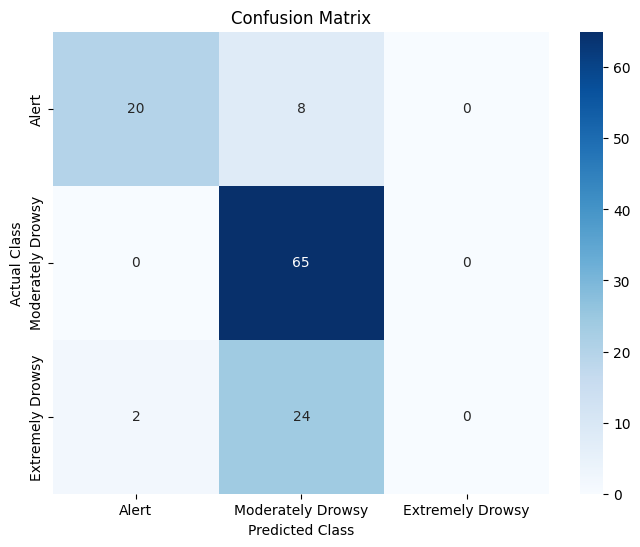

In [43]:
test_results = pd.DataFrame(columns=['subject_test', 'accuracy', 'loss'])

for subject_test_order in range(len(subject_test_list)):
    subject_test = subject_test_list[subject_test_order]
    
    # Create combined dataframe to store data of 1 subject_test
    ECG_features_test_df = ECG_dataframe(subject_test_order, ECG_features_testcases)

    EEG_features_test_df_list = EEG_dataframe_list(subject_test_order, EEG_features_testcases, channelList_testcases)

    EEG_features_test_df = pd.DataFrame()

    for EEG_channel in EEG_channel_list:
        EEG_features_append = EEG_features_test_df_list[EEG_channel-1].copy()
        EEG_features_append.columns = [f'{col}_{EEG_channel}' for col in EEG_features_append.columns]
        EEG_features_test_df = pd.concat([EEG_features_test_df, EEG_features_append], axis=1)

    ord_epoch_test = ord_dataframe(subject_test_order, ord_60min_testcases, numClasses)

    print(f'Subject test: {subject_test}')
    print(ord_epoch_test['class name'].value_counts())

    combined_test_data = combined_dataframe(EEG_features_test_df, ECG_features_test_df, ord_epoch_test)

    combined_test_data.insert(1, 'Initial_KSS', initial_kss[subject_test-1])
    combined_test_data.insert(0, 'subject', subject_test)

    combined_test_data = combined_test_data.dropna()

    # combined_test_data.insert(0, 'subject_test', subject_test)

    # Prepare X_test, y_test of 1 subject_test
    X_test = combined_test_data.loc[:, ~combined_test_data.columns.isin(excluded_columns)]
    y_test = combined_test_data['ORD class']

    # Scaling
    X_test_scaled = scaler.transform(X_test)

    # Encoding labels
    y_test_encoded = encoder.transform(pd.DataFrame(y_test))

    # Model Evaluation
    test_loss, test_acc = final_model.evaluate(X_test_scaled, y_test_encoded)
    
    new_data = pd.DataFrame({'subject_test': [subject_test], 'accuracy': [test_acc], 'loss': [test_loss]})
    test_results = pd.concat([test_results, new_data], axis=0)

    print(f'Test Accuracy: {test_acc}, Test Loss: {test_loss}')

    # Print Confusion Matrix, Accuracy Report
    ### Predict the test set
    predictions = final_model.predict(X_test_scaled)
    predicted_classes = np.argmax(predictions, axis=1)

    ### True classes (convert from one-hot if necessary)
    true_classes = np.argmax(y_test_encoded, axis=1)  # Make sure y_encoded is not class indices

    unique_classes = np.unique(np.concatenate((predicted_classes, true_classes)))
    max_class_label = unique_classes.max()
    class_labels = list(range(max_class_label + 1))

    ### Confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes, labels=class_labels)
    print("Confusion Matrix:\n", conf_matrix)

    ### Class-wise accuracy
    class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    print("Class-wise Accuracy:", class_wise_accuracy)

    ### Detailed classification report
    target_names = [f'Class{i}' for i in class_labels]
    report = classification_report(true_classes, predicted_classes, labels=class_labels, target_names=target_names)

    print(report)

    y_test_hat = final_model.predict(X_test_scaled)
    y_test_hat_classes = np.argmax(y_test_hat, axis=1)
    y_test_compare = y_test-1

    # Compute the confusion matrix
    cm = confusion_matrix(y_test_compare, y_test_hat_classes)
    def plot_confusion_matrix(cm, class_names):
        """
        Plots a confusion matrix using Seaborn's heatmap().
        """
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Class')
        plt.xlabel('Predicted Class')
        plt.show()

    if numClasses == 3:
        class_names = ['Alert', 'Moderately Drowsy', 'Extremely Drowsy']
    elif numClasses == 2:
        class_names = ['Alert', 'Drowsy']
    # Assuming 'class_names' is a list of your class names, such as class_names = ['Class1', 'Class2', 'Class3']
    plot_confusion_matrix(cm, class_names)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


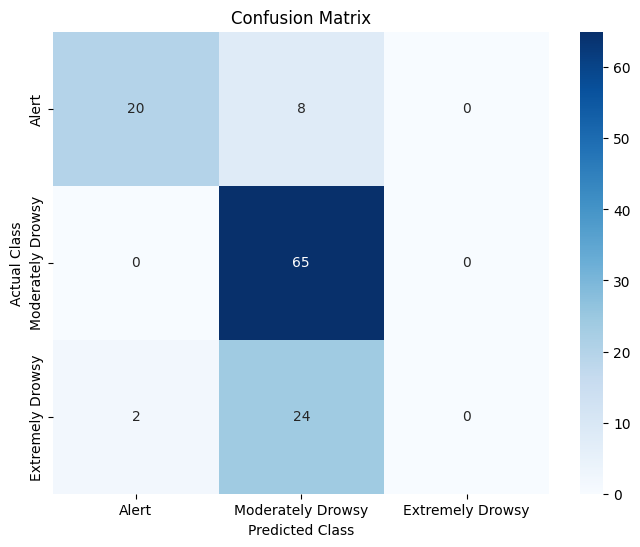

In [44]:
y_test_hat = final_model.predict(X_test_scaled)
y_test_hat_classes = np.argmax(y_test_hat, axis=1)
y_test_compare = y_test-1

import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test_compare, y_test_hat_classes)
def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

if numClasses == 3:
    class_names = ['Alert', 'Moderately Drowsy', 'Extremely Drowsy']
elif numClasses == 2:
    class_names = ['Alert', 'Drowsy']
# Assuming 'class_names' is a list of your class names, such as class_names = ['Class1', 'Class2', 'Class3']
plot_confusion_matrix(cm, class_names)